# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Sun May 14 13:00:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os

base_path = "/content/drive/MyDrive/Interpretability" 

In [ ]:
!pip install numpy==1.23

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install git+https://github.com/neelnanda-io/TransformerLens

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neelnanda-io/TransformerLens to /tmp/pip-req-build-d1p_biov
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens /tmp/pip-req-build-d1p_biov
  Resolved https://github.com/neelnanda-io/TransformerLens to commit 49edbec5424081182ef090265e2e6112153deffc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install devtools
from devtools import debug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm.notebook as tqdm

import random
import time

# from google.colab import drive
from pathlib import Path
import pickle
import os


import matplotlib.pyplot as plt

%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc
import collections
import copy

# import comet_ml
import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets

from pprint import pprint

In [ ]:
from transformer_lens.utils import (
    gelu_new,
    to_numpy,
    get_corner,
    lm_cross_entropy_loss,
)  # Helper functions
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from transformers import AutoModelForCausalLM

model_name = "solu-6l-pile"
layer_ending = "mlp.hook_mid"
model = HookedTransformer.from_pretrained(model_name).to(device)

Using pad_token, but it is not set yet.


Loaded pretrained model solu-6l-pile into HookedTransformer
Moving model to device:  cuda


In [ ]:
# from transformers import AutoModelForCausalLM

# model_name = "gpt2-small"
# layer_ending = "mlp.hook_post"
# model = HookedTransformer.from_pretrained(model_name).to(device)

In [ ]:
# from transformers import AutoModelForCausalLM

# model_name = "gpt2-xl"
# layer_ending = "mlp.hook_post"
# model = HookedTransformer.from_pretrained(model_name).to(device)

In [ ]:
# from transformers import AutoModelForCausalLM

# model_name = "pythia-70m"
# layer_ending = "mlp.hook_post"
# model = HookedTransformer.from_pretrained(model_name).to(device)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer

aug_model_checkpoint = "distilbert-base-uncased"
aug_model = AutoModelForMaskedLM.from_pretrained(aug_model_checkpoint).to(device)
aug_tokenizer = AutoTokenizer.from_pretrained(aug_model_checkpoint)

# Code

In [ ]:
import requests
import re
import json

# parser = re.compile("<span class='token' style='background-color:rgb\([0-9]{1,3}, [0-9]{1,3}, [0-9]{1,3}\)' >")
parser = re.compile('\{\"tokens\": ')
def get_snippets(model_name, layer, neuron):
  """Get the max activating dataset examples for a given neuron in a model"""
  base_url = f"https://neuroscope.io/{model_name}/{layer}/{neuron}.html"

  response = requests.get(base_url)
  webpage = response.text
  
  parts = parser.split(webpage)
  snippets = []
  for i, part in enumerate(parts):    
    if i == 0 or i % 2 != 0:
      continue

    token_str = part.split(', "values": ')[0]

    tokens = json.loads(token_str)

    snippet = "".join(tokens)

    snippets.append(snippet)
    
  if len(snippets) != 20:
    raise Exception
  return snippets

In [ ]:
snippets = get_snippets("solu-6l-pile", 3, 13)

In [ ]:
act_parser = re.compile('<h4>Max Act: <b>')
def get_max_activations(model_name, layer, neuron, n=1):
  """Get the max activating dataset examples for a given neuron in a model"""
  base_url = f"https://neuroscope.io/{model_name}/{layer}/{neuron}.html"

  response = requests.get(base_url)
  webpage = response.text
  
  parts = act_parser.split(webpage)
  activations = []
  for i, part in enumerate(parts):    
    if i == 0:
      continue

    activation = float(part.split('</b>')[0])

    activations.append(activation)
    if len(activations) >= n:
      break
    
  if len(activations) != min(20, n):
    raise Exception
  return activations if n > 1 else activations[0]

In [ ]:
from string import punctuation

class WordTokenizer:
  """Simple tokenizer for splitting text into words"""

  def __init__(self, split_tokens, stick_tokens):
    self.split_tokens = split_tokens
    self.stick_tokens = stick_tokens

  def __call__(self, text):
    return self.tokenize(text)

  def is_split(self, char):
    """Split on any non-alphabet chars unless excluded, and split on any specified chars"""
    return char in self.split_tokens or (not char.isalpha() and char not in stick_tokens)
  
  def tokenize(self, text):
    """Tokenize text, preserving all characters"""
    tokens = []
    current_token = ""
    for char in text:
      if self.is_split(char):
        tokens.append(current_token)
        tokens.append(char)
        current_token = ""
        continue
      current_token += char
    tokens.append(current_token)
    tokens = [token for token in tokens if token]
    return tokens

stick_tokens = {"'"}
word_tokenizer = WordTokenizer(set(), stick_tokens)

In [ ]:
%%time

import gzip
from collections import Counter, defaultdict

if False:
  file_ids = "abcdefghijklmnopqrstuvwxyz"

  word_counter = Counter()

  tags = ["NOUN", "VERB", "ADJ", "ADV", "PRON", "DET", "ADP", "NUM", "CONJ", "PRT", "X", ".", "END_", "START_"]

  tags = [f"_{tag}" for tag in tags]

  for c in file_ids:
    print(f"Processing {c}")
    c_counter = Counter()

    with gzip.open(f"{base_path}/data/ngrams/googlebooks-eng-all-1gram-20120701-{c}.gz") as ifh:
      for j, line in enumerate(ifh):
        if j % 5000000 == 0:
          print(f"{j} complete")

        line = line.decode()
        line = line.strip()
        text, year, count, book_count = line.split("\t")

        if int(year) < 1950:
          continue

        if "_" in text:
          continue

        c_counter[text] += int(count)

      print("Removing rare words")
      min_count = 2000
      common_c_counter = Counter()
      for i, (word, count) in enumerate(c_counter.most_common()):
        if i % 5000000 == 0:
          print(f"{i} complete")

        if count < min_count:
          break
        common_c_counter[word] += count

      word_counter.update(common_c_counter)

  print("Counting casings")
  word_to_casings = defaultdict(list)
  for word, count in word_counter.most_common():
    word_norm = word.lower()
    word_to_casings[word_norm].append((word, count))

  with open(f"{base_path}/data/ngrams/word_to_casings.json", "w") as ifh:
    json.dump(word_to_casings, ifh, ensure_ascii=False)

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 20.3 µs


In [ ]:
with open(f"{base_path}/data/ngrams/word_to_casings.json") as ifh:
  word_to_casings = json.load(ifh)

In [ ]:
import copy
from nltk.corpus import stopwords
from string import punctuation
import re
from scipy.special import softmax

class ContextualAugmenter:
  """Uses BERT to generate variations on input text by masking words and substituting with most likely predictions"""

  def __init__(self, model, model_tokenizer, word_tokenizer, neuron_model, device="cuda:0"):
    self.model = model
    self.model_tokenizer = model_tokenizer
    self.stops = set(stopwords.words('english'))
    self.punctuation_set = set(punctuation)
    self.to_strip = " " + punctuation
    self.word_tokenizer = word_tokenizer
    self.device = device

  def augment(self, text, max_char_position=None, exclude_stopwords=False, n=5, mask_num=1, important_tokens=None, all_but_important=False, only_important=False, **kwargs):
    """Generate new texts given an initial text and a masking scheme by auto-regressively predicting each masked token with BERT"""

    if all_but_important and important_tokens is None:
      raise ValueError("When all_but_important is True you must provide one or more important_tokens")

    if only_important and important_tokens is None:
      raise ValueError("When only_important is True you must provide one or more important_tokens")

    if only_important and all_but_important:
      raise ValueError("only_important and all_but_important are not allowed to be True at the same time")

    joiner = ""
    tokens = self.word_tokenizer(text)
    
    new_texts = []
    positions = []

    important_tokens = {token.strip(self.to_strip).lower() for token in important_tokens}

    seen_prompts = set()

    for i, token in enumerate(tokens):
      norm_token = token.strip(self.to_strip).lower()
      if not token or word_tokenizer.is_split(token) or (exclude_stopwords and norm_token in self.stops) or (important_tokens is not None and norm_token not in important_tokens):
        continue

      masked_tokens = copy.deepcopy(tokens)
      masked = 0
      
      if not all_but_important and not only_important:
        # Mask mask_num consecutive tokens
        masking_index = 0
        while masked < mask_num and i + masking_index < len(masked_tokens):
          if not word_tokenizer.is_split(masked_tokens[i + masking_index]):
            masked_tokens[i + masking_index] = "[MASK]"
            masked += 1
          masking_index += 1

      else:
        for j, cand_token in enumerate(tokens):
          norm_cand_token = cand_token.strip(self.to_strip).lower()
          # Basic token checks plus check if the token is important and therefore whether it should be masked
          if (not cand_token or word_tokenizer.is_split(cand_token) or 
              (exclude_stopwords and norm_cand_token in self.stops) or 
              (norm_cand_token in important_tokens and all_but_important) or 
              (norm_cand_token not in important_tokens and only_important)):
            continue
          masked_tokens[j] = "[MASK]"
          masked += 1
        
      before = tokens[:i]
      before_text = joiner.join(before)
      position = len(before_text)

      # Don't bother if we're beyond the max activating token, as these tokens have no effect on the activation
      if max_char_position is not None and position > max_char_position:
        break

      start_masked_text = joiner.join(masked_tokens)
      masked_matrix = [[copy.deepcopy(start_masked_text) for _ in range(n)] for _ in range(masked + 1)]

      for j in range(masked):
        masked_texts = masked_matrix[j]
        inputs = self.model_tokenizer(masked_texts, padding=True, return_tensors="pt").to(self.device)
        token_probs = softmax(self.model(**inputs).logits.cpu().detach().numpy(), axis=-1)
        inputs = inputs.to("cpu")

        chosen_tokens = set()
        
        for k in range(n):
          # Get the index of the first masked token
          mask_token_index = np.argwhere(inputs["input_ids"][k] == self.model_tokenizer.mask_token_id)[0, 0]
          mask_token_probs = token_probs[k, mask_token_index, :]
          # We negate the array before argsort to get the largest, not the smallest, logits
          top_probs = -np.sort(-mask_token_probs).transpose()
          top_tokens = np.argsort(-mask_token_probs).transpose()

          # Substitute the given token with the best predictions
          for l, top_token in enumerate(top_tokens):
            next_top_prob = top_probs[l + 1]
            candidate_token = self.model_tokenizer.decode(top_token)
            if candidate_token in chosen_tokens and next_top_prob > 0.00001:
              continue

            # Check that the predicted token isn't the same as the token that was already there
            normalised_candidate = candidate_token.strip(self.to_strip).lower() if candidate_token not in self.punctuation_set else candidate_token
            normalised_token = token.strip(self.to_strip).lower() if token not in self.punctuation_set else token
            
            if normalised_candidate != normalised_token:
              chosen_token = candidate_token
              chosen_tokens.add(chosen_token)
              break

          # BERT uses ## to denote a tokenisation within a word, so we remove it to glue the word back together
          masked_matrix[j + 1][k] = masked_texts[k].replace(self.model_tokenizer.mask_token, candidate_token, 1).replace(" ##", "")

      for new_prompt in masked_matrix[-1]:
        if new_prompt in seen_prompts:
          continue
        new_texts.append(new_prompt)
        positions.append(position)
        seen_prompts.add(new_prompt)

      if all_but_important or only_important:
        break       
    
    return new_texts, positions

In [ ]:
from ast import Continue
import copy
from nltk.corpus import stopwords
from string import punctuation
import re
from scipy.special import softmax

class FastAugmenter:
  """Uses word embeddings to generate variations on input text by replacing words with other words with similar embeddings"""

  def __init__(self, model, model_tokenizer, word_tokenizer, neuron_model, device="cuda:0"):
    self.model = model
    self.model_tokenizer = model_tokenizer
    self.stops = set(stopwords.words('english'))
    self.punctuation_set = set(punctuation)
    self.to_strip = " " + punctuation
    self.word_tokenizer = word_tokenizer
    self.device = device

  def augment(self, text, max_char_position=None, exclude_stopwords=False, n=5, important_tokens=None, **kwargs):
    joiner = ""
    tokens = self.word_tokenizer(text)
    
    new_texts = []
    positions = []

    important_tokens = {token.strip(self.to_strip).lower() for token in important_tokens}

    seen_prompts = set()

    # Gather all tokens to be substituted
    tokens_to_sub = []

    # Mask important tokens   
    masked_token_sets = []
    masked_texts = []

    masked_tokens = []

    for i, token in enumerate(tokens):
      norm_token = token.strip(self.to_strip).lower() if any(c.isalpha() for c in token) else token

      if not token or word_tokenizer.is_split(token) or (exclude_stopwords and norm_token in self.stops) or (important_tokens is not None and norm_token not in important_tokens):
        continue
      
      # If no alphanumeric characters, we'll do a special substitution rather than using BERT
      if not any(c.isalpha() for c in token):
        continue

      before = tokens[:i]
      before_text = joiner.join(before)
      position = len(before_text)

      # Don't bother if we're beyond the max activating token, as these tokens have no effect on the activation
      if max_char_position is not None and position > max_char_position:
        break

      copy_tokens = copy.deepcopy(tokens)
      copy_tokens[i] = "[MASK]"     
      masked_token_sets.append((copy_tokens, position))
      masked_texts.append(joiner.join(copy_tokens))

      masked_tokens.append(token)

    # pprint(masked_texts)
    if len(masked_texts) == 0:
      return [], []
    
    inputs = self.model_tokenizer(masked_texts, padding=True, return_tensors="pt").to(self.device)
    token_probs = softmax(self.model(**inputs).logits.cpu().detach().numpy(), axis=-1)
    inputs = inputs.to("cpu")

    chosen_tokens = set()

    new_texts = []
    positions = []

    seen_texts = set()

    for i, (masked_token_set, char_position) in enumerate(masked_token_sets):    
      mask_token_index = np.argwhere(inputs["input_ids"][i] == self.model_tokenizer.mask_token_id)[0, 0]

      mask_token_probs = token_probs[i, mask_token_index, :]

      # We negate the array before argsort to get the largest, not the smallest, logits
      top_probs = -np.sort(-mask_token_probs).transpose()
      top_tokens = np.argsort(-mask_token_probs).transpose()

      subbed = 0

      # Substitute the given token with the best predictions
      for l, (top_token, top_prob) in enumerate(zip(top_tokens, top_probs)):
        if top_prob < 0.00001:
          break        

        candidate_token = self.model_tokenizer.decode(top_token)

        # print(candidate_token)

        # Check that the predicted token isn't the same as the token that was already there
        normalised_candidate = candidate_token.strip(self.to_strip).lower() if candidate_token not in self.punctuation_set else candidate_token
        normalised_token = token.strip(self.to_strip).lower() if token not in self.punctuation_set else token
        
        if normalised_candidate == normalised_token or not any(c.isalpha() for c in candidate_token):
          continue

        # Get most common casing of the word
        most_common_casing = word_to_casings.get(candidate_token, [(candidate_token, 1)])[0][0]

        original_token = masked_tokens[i]
        # Title case normally has meaning (e.g., start of sentence, in a proper noun, etc.) so follow original token, otherwise use most common
        best_casing = candidate_token.title() if original_token.istitle() else most_common_casing

        new_token_set = copy.deepcopy(masked_token_set)
        # BERT uses ## to denote a tokenisation within a word, so we remove it to glue the word back together
        masked_text = joiner.join(new_token_set)
        new_text = masked_text.replace(self.model_tokenizer.mask_token, best_casing, 1).replace(" ##", "")

        if new_text in seen_texts:
          continue

        new_texts.append(new_text)
        positions.append(char_position)
        subbed += 1

        if subbed >= n:
          break

    return new_texts, positions

In [ ]:
fast_aug = FastAugmenter(aug_model, aug_tokenizer, word_tokenizer, model)

In [ ]:
contextual_aug = ContextualAugmenter(aug_model, aug_tokenizer, word_tokenizer, model)

In [ ]:
%%time

new_prompts, _ = fast_aug.augment("J.C.C. is supported by a grant from the UK Medical Research Council", important_tokens={"is", "supported", "by", "a", "grant", "from", "the", "UK", "Medical", "Research", "Council"}, n=10)

CPU times: user 2.32 s, sys: 170 ms, total: 2.49 s
Wall time: 2.56 s


In [ ]:
%%time

contextual_aug.augment("J.C.C. is supported by a grant from the UK Medical Research Council", important_tokens={"is", "supported", "by", "a", "grant", "from", "the", "UK", "Medical", "Research", "Council"}, n=10)

CPU times: user 1.45 s, sys: 324 ms, total: 1.77 s
Wall time: 3.27 s


(['J.C.C. was supported by a grant from the UK Medical Research Council',
  'J.C.C. has supported by a grant from the UK Medical Research Council',
  'J.C.C. currently supported by a grant from the UK Medical Research Council',
  'J.C.C. were supported by a grant from the UK Medical Research Council',
  'J.C.C. are supported by a grant from the UK Medical Research Council',
  'J.C.C. , supported by a grant from the UK Medical Research Council',
  'J.C.C. research supported by a grant from the UK Medical Research Council',
  'J.C.C. - supported by a grant from the UK Medical Research Council',
  'J.C.C. ltd supported by a grant from the UK Medical Research Council',
  'J.C.C. foundation supported by a grant from the UK Medical Research Council',
  'J.C.C. is funded by a grant from the UK Medical Research Council',
  'J.C.C. is financed by a grant from the UK Medical Research Council',
  'J.C.C. is recognised by a grant from the UK Medical Research Council',
  'J.C.C. is backed by a gran

In [ ]:
# import gensim.downloader

# vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')

# vectors.most_similar('twitter')

In [ ]:
from pprint import pprint
from collections import defaultdict
from string import punctuation
import re
import copy

splitter = re.compile("[\.!\\n]")

def sentence_tokenizer(str_tokens):
  """Split tokenized text into sentences"""
  sentences = []
  sentence = []
  sentence_to_token_indices = defaultdict(list)
  token_to_sentence_indices = {}
  
  for i, str_token in enumerate(str_tokens):
    sentence.append(str_token)
    sentence_to_token_indices[len(sentences)].append(i)
    token_to_sentence_indices[i] = len(sentences)
    if splitter.search(str_token) is not None or i + 1 == len(str_tokens):
      sentences.append(sentence)
      sentence = []    

  return sentences, sentence_to_token_indices, token_to_sentence_indices


def prune(model, layer, neuron, prompt, max_length=1024, proportion_threshold=-0.5, absolute_threshold=None, window=0, return_maxes=False, **kwargs):
  """Prune an input prompt to the shortest string that preserves x% of neuron activation on the most activating token."""

  prepend_bos = True
  tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
  str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)

  if len(tokens[0]) > max_length:
    tokens = tokens[0, :max_length].unsqueeze(0)

  logits, cache = model.run_with_cache(tokens)
  activations = cache[layer][0, :, neuron]

  initial_max = torch.max(activations).cpu().item()
  initial_argmax = torch.argmax(activations).cpu().item()

  sentences, sentence_to_token_indices, token_to_sentence_indices = sentence_tokenizer(str_tokens)

  max_sentence_index = token_to_sentence_indices[initial_argmax]
  relevant_str_tokens = [str_token for sentence in sentences[:max_sentence_index + 1] for str_token in sentence]

  shortest_successful_prompt = None
  final_max_index = None

  count = 0
  for i, str_token in reversed(list(enumerate(relevant_str_tokens[:max(0, initial_argmax - window + 1)]))):
    count += 1
    if count >= 20 and count % 10 != 0:
      continue

    truncated_prompt = relevant_str_tokens[i:]

    joined = "".join(truncated_prompt)
    
    truncated_tokens = model.to_tokens(joined, prepend_bos=prepend_bos)
    logits, cache = model.run_with_cache(truncated_tokens)
    truncated_activations = cache[layer][0, :, neuron]
    truncated_argmax = torch.argmax(truncated_activations).cpu().item() + i
    final_max_index = torch.argmax(truncated_activations).cpu().item()

    if prepend_bos:
      truncated_argmax -= 1
      final_max_index -= 1
    truncated_max = torch.max(truncated_activations).cpu().item()

    shortest_prompt = truncated_prompt

    if truncated_argmax == initial_argmax and (
        (truncated_max - initial_max) / initial_max > proportion_threshold or 
        (absolute_threshold is not None and truncated_max >= absolute_threshold)):        
      shortest_successful_prompt = truncated_prompt
      break

  pruned_sentence = "".join(shortest_successful_prompt) if shortest_successful_prompt is not None else None
  
  if return_maxes:
    return pruned_sentence, final_max_index, initial_max, truncated_max
  return pruned_sentence, final_max_index


def augment(model, layer, index, prompt, aug, max_length=1024, inclusion_threshold=-0.5, exclusion_threshold=-0.5, n=5, **kwargs):
  """Generate variations of a prompt using an augmenter"""
  prepend_bos = True
  tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
  str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)

  # print(prompt)

  if len(tokens[0]) > max_length:
    tokens = tokens[0, :max_length].unsqueeze(0)

  logits, cache = model.run_with_cache(tokens)
  activations = cache[layer][0, :, index]

  initial_max = torch.max(activations).cpu().item()
  initial_argmax = torch.argmax(activations).cpu().item()
  max_char_position = len("".join(str_tokens[int(prepend_bos):initial_argmax + 1]))

  positive_prompts = [(prompt, initial_max, 1)]
  negative_prompts = []

  if n == 0:
    return positive_prompts, negative_prompts
  
  aug_prompts, aug_positions = aug.augment(prompt, max_char_position=max_char_position, n=n, **kwargs)
  if not aug_prompts:
    return positive_prompts, negative_prompts
    
  aug_tokens = model.to_tokens(aug_prompts, prepend_bos=prepend_bos)

  aug_logits, aug_cache = model.run_with_cache(aug_tokens)
  all_aug_activations = aug_cache[layer][:, :, index]

  for aug_prompt, char_position, aug_activations in zip(aug_prompts, aug_positions, all_aug_activations):
    aug_max = torch.max(aug_activations).cpu().item()
    aug_argmax = torch.argmax(aug_activations).cpu().item()

    # TODO implement this properly - when we mask multiple tokens, if they cross the max_char_position this will not necessarily be correct
    if char_position < max_char_position:
      new_str_tokens = model.to_str_tokens(aug_prompt, prepend_bos=prepend_bos)
      aug_argmax += len(new_str_tokens) - len(str_tokens)

    proportion_drop = (aug_max - initial_max) / initial_max

    if proportion_drop >= inclusion_threshold:
      positive_prompts.append((aug_prompt, aug_max, proportion_drop))
    elif proportion_drop < exclusion_threshold:
      negative_prompts.append((aug_prompt, aug_max, proportion_drop))

  return positive_prompts, negative_prompts

In [ ]:
import math


def batch(arr, n=None, batch_size=None):
    if n is None and batch_size is None:
        raise ValueError("Either n or batch_size must be provided")
    if n is not None and batch_size is not None:
        raise ValueError("Either n or batch_size must be provided, not both")

    if n is not None:
        batch_size = math.floor(len(arr) / n)
    elif batch_size is not None:
        n = math.ceil(len(arr) / batch_size)

    extras = len(arr) - (batch_size * n)
    groups = []
    group = []
    added_extra = False
    for element in arr:
        group.append(element)
        if len(group) >= batch_size:
            if extras and not added_extra:
                extras -= 1
                added_extra = True
                continue
            groups.append(group)
            group = []
            added_extra = False

    if group:
        groups.append(group)

    return groups

In [ ]:
def fast_prune(model, layer, neuron, prompt, max_length=1024, proportion_threshold=-0.5, absolute_threshold=None, window=0, return_maxes=False, cutoff=30, batch_size=4, max_post_context_tokens=5, skip_threshold=0, skip_interval=5, return_intermediates=False, **kwargs):
  """Prune an input prompt to the shortest string that preserves x% of neuron activation on the most activating token."""

  prepend_bos = True
  tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
  str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)

  if len(tokens[0]) > max_length:
    tokens = tokens[0, :max_length].unsqueeze(0)

  logits, cache = model.run_with_cache(tokens)
  activations = cache[layer][0, :, neuron]

  initial_max = torch.max(activations).cpu().item()
  initial_argmax = torch.argmax(activations).cpu().item()

  sentences, sentence_to_token_indices, token_to_sentence_indices = sentence_tokenizer(str_tokens)

  max_sentence_index = token_to_sentence_indices[initial_argmax]
  relevant_str_tokens = [str_token for sentence in sentences[:max_sentence_index + 1] for str_token in sentence]

  prior_context = relevant_str_tokens[:initial_argmax + 1]

  post_context = relevant_str_tokens[initial_argmax + 1:]

  shortest_successful_prompt = None
  final_max_index = None

  truncated_prompts = []
  added_tokens = []

  count = 0
  for i, str_token in reversed(list(enumerate(prior_context[:max(0, initial_argmax - window + 1)]))):
    count += 1

    if count > cutoff:
      break

    if count >= skip_threshold and count % skip_interval != 0:
      continue

    truncated_prompt = prior_context[i:]
    joined = "".join(truncated_prompt)
    truncated_prompts.append(joined)
    added_tokens.append(i)

  batched_truncated_prompts = batch(truncated_prompts, batch_size=batch_size)
  batched_added_tokens = batch(added_tokens, batch_size=batch_size)
  
  finished = False
  intermediates = []
  for i, (truncated_batch, added_tokens_batch) in enumerate(zip(batched_truncated_prompts, batched_added_tokens)):
    # print("length", len(truncated_batch))
    # pprint(truncated_batch)

    truncated_tokens = model.to_tokens(truncated_batch, prepend_bos=prepend_bos)

    # pprint(truncated_tokens)

    logits, cache = model.run_with_cache(truncated_tokens)
    all_truncated_activations = cache[layer][:, :, neuron]

    # print("shape", all_truncated_activations.shape)

    for j, truncated_activations in enumerate(all_truncated_activations):
      num_added_tokens = added_tokens_batch[j]
      # print("single shape", truncated_activations.shape)
      truncated_argmax = torch.argmax(truncated_activations).cpu().item() + num_added_tokens
      final_max_index = torch.argmax(truncated_activations).cpu().item()

      if prepend_bos:
        truncated_argmax -= 1
        final_max_index -= 1
      truncated_max = torch.max(truncated_activations).cpu().item()
    
      # trunc_logits, trunc_cache = model.run_with_cache(model.to_tokens(truncated_batch[j], prepend_bos=prepend_bos))
      # trunc_activations = trunc_cache[layer][0, :, neuron]

      # print(truncated_activations)
      # print(trunc_activations)
      # print("truncated_argmax", truncated_argmax)
      # print(truncated_max)

      shortest_prompt = truncated_batch[j]

      if not shortest_prompt.startswith("<|endoftext|>"):
        truncated_str_tokens = model.to_str_tokens(truncated_batch[j], prepend_bos=False)
        intermediates.append((shortest_prompt, truncated_str_tokens[0], truncated_max))

      if (truncated_argmax == initial_argmax and (
          (truncated_max - initial_max) / initial_max > proportion_threshold or 
          (absolute_threshold is not None and truncated_max >= absolute_threshold))) or (i == len(batched_truncated_prompts) - 1 and j == len(all_truncated_activations) - 1):        
        shortest_successful_prompt = shortest_prompt
        finished = True
        break
    
    if finished:
      break

  # if shortest_successful_prompt is None:
  #   pruned_sentence = "".join(relevant_str_tokens)
  #   final_max_index = initial_argmax
  # else:
  pruned_sentence = "".join(shortest_successful_prompt)

  if max_post_context_tokens is not None:
    pruned_sentence += "".join(post_context[:max_post_context_tokens])
  
  if return_maxes:
    return pruned_sentence, final_max_index, initial_max, truncated_max

  elif return_intermediates:
    return pruned_sentence, intermediates

  return pruned_sentence, final_max_index

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def visualise(tokens_and_activations, tokens_and_importances, max_index=None, title=None, truncate=False, labels=["Activation", "Importance"], **kwargs):
  """Visualise relative token activation and importance"""
  if max_index is None:
    max_index = len(tokens_and_activations)

  zero_width = u'\u200b'
  token_counter = Counter()
  data = {}
  count = 0

  for i, ((token, importance), (_, activation)) in enumerate(zip(tokens_and_importances, tokens_and_activations)):
    if token == "<|endoftext|>":
      continue

    if i > max_index and truncate:
      break

    # This is a horrible hack to allow us to have a dict with the "same" token as multiple keys - by adding zero width spaces the tokens look the same but are actually different
    seen_count = token_counter[token]
    add = zero_width * seen_count
    deduped_token = token + add
    # Have to escape dollars so matplotlib doesn't interpret them as latex
    deduped_token = deduped_token.replace("$", "\$")
    data[deduped_token] = [activation, importance]
    token_counter[token] += 1
    count += 1

  df = pd.DataFrame(data, index=labels)
  plt.figure(figsize=[int(count * 1.5), 1.2])
  sns.heatmap(df, vmin=0, vmax=1, xticklabels=True, annot=True)

  if title is not None:
    title = title.replace("$", "\$")
    plt.title(title)

In [ ]:
def measure_importance(model, layer, neuron, prompt, max_length=1024, max_activation=None, masking_token=1, threshold=0.8, **kwargs):
  """Compute a measure of token importance by masking each token and measuring the drop in activation on the max activating token"""
  
  prepend_bos = True
  tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
  str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)

  if len(tokens[0]) > max_length:
    tokens = tokens[0, :max_length].unsqueeze(0)

  logits, cache = model.run_with_cache(tokens)
  activations = cache[layer][0, :, neuron]

  initial_max = torch.max(activations).cpu().item()
  initial_argmax = torch.argmax(activations).cpu().item()

  if max_activation is None:
    max_activation = initial_max
  scale = min(1, initial_max / max_activation)

  tokens_and_activations = [(str_token, round(activation.cpu().item() / max_activation, 3)) for str_token, activation in zip(str_tokens, activations)]
  important_tokens = []
  tokens_and_importances = []

  shortest_successful_prompt = None
  for i, str_token in enumerate(str_tokens):
    joined = "".join(str_tokens)
    
    masked_tokens = model.to_tokens(joined, prepend_bos=False)

    masked_tokens[0, i] = masking_token

    logits, cache = model.run_with_cache(masked_tokens)
    masked_activations = cache[layer][0, :, neuron]
    masked_max = masked_activations[initial_argmax].cpu().item()
    normalised_activation = (1 - (masked_max / initial_max))
    
    tokens_and_importances.append((str_token, masked_max, normalised_activation))
    if normalised_activation >= threshold and str_token != "<|endoftext|>":
      important_tokens.append(str_token)

  return tokens_and_importances, initial_max, important_tokens, tokens_and_activations, initial_argmax

In [ ]:
import numpy as np
import copy

def fast_measure_importance(model, layer, neuron, prompt, initial_argmax=None, max_length=1024, max_activation=None, masking_token=1, threshold=0.8, scale_factor=1, return_all=False, activation_threshold=0.1, **kwargs):
  """Compute a measure of token importance by masking each token and measuring the drop in activation on the max activating token"""
  
  prepend_bos = True
  tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
  str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)

  if len(tokens[0]) > max_length:
    tokens = tokens[0, :max_length].unsqueeze(0)

  # logits, cache = model.run_with_cache(tokens)

  # print(tokens_and_activations)

  importances_matrix = []

  shortest_successful_prompt = None
  # cutoff = 50

  masked_prompts = tokens.repeat(len(tokens[0]) + 1, 1)

  # print(f"{len(masked_prompts)=}, {initial_argmax=}, {starting_point=}")

  for i in range(1, len(masked_prompts)):
    masked_prompts[i, i - 1] = masking_token

  # for i, str_token in enumerate(str_tokens):
  #   if i >= cutoff:
  #     break

  #   masked_tokens = tokens

  #   if i >= len(masked_tokens[0]):
  #     continue

  #   token_to_mask = copy.deepcopy(tokens[0, i])
  #   masked_tokens[0, i] = masking_token

  #   masked_prompts.append(masked_tokens[0])
  #   tokens[0, i] = token_to_mask

  # pprint(masked_prompts)
  
  logits, cache = model.run_with_cache(masked_prompts)
  all_masked_activations = cache[layer][1:, :, neuron]

  activations = cache[layer][0, :, neuron]

  if initial_argmax is None:
    initial_argmax = torch.argmax(activations).cpu().item()
  else:
    # This could be wrong
    initial_argmax = min(initial_argmax, len(activations) - 1)

  # print(activations)
  # print(activation_threshold)
  # activation_indexes = [i for i, activation in enumerate(activations) if activation * scale_factor / max_activation > activation_threshold]
  # print(activation_indexes)
  # final_activating = initial_argmax if len(activation_indexes) == 0 else activation_indexes[-1]
    
  initial_max = activations[initial_argmax].cpu().item()

  if max_activation is None:
    max_activation = initial_max
  scale = min(1, initial_max / max_activation)

  # print("scale_factor measure_importance", scale_factor)

  tokens_and_activations = [[str_token, round(activation.cpu().item() * scale_factor / max_activation, 3)] for str_token, activation in zip(str_tokens, activations)]
  important_tokens = []
  tokens_and_importances = [[str_token, 0] for str_token in str_tokens]

  for i, masked_activations in enumerate(all_masked_activations):
    if return_all:
      # Get importance of the given token for all tokens
      importances_row = []
      for j, activation in enumerate(masked_activations):
        activation = activation.cpu().item()
        normalised_activation = (1 - (activation / activations[j].cpu().item()))
        importances_row.append((str_tokens[j], normalised_activation))

      # for j, str_token in enumerate(str_tokens[cutoff:]):
      #   importances_row.append((str_token, 0))

      # print("importances_row", importances_row)
      importances_matrix.append(np.array(importances_row))

    masked_max = masked_activations[initial_argmax].cpu().item()
    normalised_activation = (1 - (masked_max / initial_max))

    str_token = tokens_and_importances[i][0]
    tokens_and_importances[i][1] = normalised_activation
    if normalised_activation >= threshold and str_token != "<|endoftext|>":
      important_tokens.append(str_token)

  # for i, str_token in enumerate(str_tokens[cutoff:]):
  #   tokens_and_importances.append((str_token, 0))  

  if return_all:
    # Flip so we have the importance of all tokens for a given token
    importances_matrix = np.array(importances_matrix)
    return importances_matrix, initial_max, important_tokens, tokens_and_activations, initial_argmax

  return tokens_and_importances, initial_max, important_tokens, tokens_and_activations, initial_argmax

In [287]:
from sklearn.model_selection import train_test_split


def layer_index_to_name(layer_index):
  return f"blocks.{layer_index}.{layer_ending}"


def train_and_eval(model, layer, neuron, aug=fast_aug, train_proportion=0.7, max_train_size=10, max_eval_size=20, fire_threshold=0.5, random_state=0, train_indexes=None, return_paths=False, **kwargs):
  if isinstance(layer, int):
    layer = layer_index_to_name(layer)

  layer_num = int(layer.split(".")[1])
  base_max_act = float(activation_matrix[layer_num, neuron])

  snippets = get_snippets(model_name, layer_num, neuron)
  # data = get_data(layer_num, neuron)

  if train_indexes is None:
    train_snippets, test_snippets = train_test_split(snippets, train_size=train_proportion, random_state=random_state)
  else:
    train_snippets = [snippet for i, snippet in enumerate(snippets) if i in train_indexes]
    test_snippets = [snippet for i, snippet in enumerate(snippets) if i not in train_indexes]
  # train_data, test_data = train_test_split(data, train_size=train_proportion, random_state=0)

  # train_data_snippets = ["".join(tokens) for tokens, activations in train_data if any(activation > fire_threshold for activation in activations)][:max_train_size] 
  train_data_snippets = []
  all_train_snippets = train_snippets + train_data_snippets

  all_info = []
  pruned_prompts = []
  for i, snippet in enumerate(all_train_snippets):
    # if i % 10 == 0:
    print(f"Processing {i + 1} of {len(all_train_snippets)}")

    pruned_prompt, _, initial_max_act, truncated_max_act = fast_prune(model, layer, neuron, snippet, return_maxes=True, **kwargs)
    pruned_prompts.append(pruned_prompt)

    # tokens = model.to_tokens(pruned_prompt, prepend_bos=True)
    # str_tokens = model.to_str_tokens(pruned_prompt, prepend_bos=True)
    # logits, cache = model.run_with_cache(tokens)
    # activations = cache[layer][0, :, neuron].cpu()
    # max_pruned_activation = torch.max(activations).item()
    scale_factor = initial_max_act / truncated_max_act
    # scale_factor = 1

    # print(scale_factor)
    # scaled_activations = activations * scale_factor / base_max_act
    
    # print(list(zip(str_tokens, activations)))

    # print(pruned_prompt)

    # print(len(pruned_prompt))

    if pruned_prompt is None:
      continue  

    info = augment_and_return(model, layer, neuron, aug, pruned_prompt, base_max_act=base_max_act, scale_factor=scale_factor, **kwargs)
    all_info.append(info)

  neuron_model = NeuronModel(layer_num, neuron, **kwargs)
  paths = neuron_model.fit(all_info)

  print("Fitted model")

  max_test_data = []
  for snippet in test_snippets:
    # pruned_prompt, _ = prune(model, layer, neuron, snippet, **kwargs)
    # if pruned_prompt is None:
    #   continue  
    tokens = model.to_tokens(snippet, prepend_bos=True)
    str_tokens = model.to_str_tokens(snippet, prepend_bos=True)
    logits, cache = model.run_with_cache(tokens)
    activations = cache[layer][0, :, neuron]
    max_test_data.append((str_tokens, activations.cpu() / base_max_act))

  # pprint(max_test_data[0])
  # print("\n\n")
  # pprint(test_data[0])

  # print("Evaluation data")
  # test_data = test_data[:max_eval_size]
  # evaluate(neuron_model, test_data, fire_threshold=fire_threshold, **kwargs)

  print("Max Activating Evaluation Data")
  try:
    stats = evaluate(neuron_model, max_test_data, fire_threshold=fire_threshold, **kwargs)
  except Exception as e:
    stats = {}
    print(f"Stats failed with error: {e}")

  if return_paths:
    return stats, paths
  return stats


def run_with_func(model, layer, neuron, aug=contextual_aug, snippets=None, eval_snippets=None, eval_data=None, max_eval_data=None, example_indexes=None, eval_indexes=None, use_base_max_act=True, visualise=True, **kwargs):
  """For a given neuron, grab the max activating dataset examples, run them through the pruning and augmentation steps, create a neuron graph, and evaluate it"""
  if snippets is None:
    snippets = []

  if eval_snippets is None:
    eval_snippets = []
    
  if example_indexes is not None or eval_indexes is not None:
    all_snippets = get_snippets("model_name", layer, neuron)
  
  if example_indexes is not None:
    snippets.extend([snippet for i, snippet in enumerate(all_snippets) if i in example_indexes])
    
  if eval_indexes is not None:
    eval_snippets.extend([snippet for i, snippet in enumerate(all_snippets) if i in eval_indexes])

  if isinstance(layer, int):
    layer = f"blocks.{layer}.{layer_ending}"

  layer_num = int(layer.split(".")[1])

  base_max_act = float(activation_matrix[layer_num, neuron]) if use_base_max_act else None

  all_info = []
  for snippet in snippets:
    pruned_prompt, _ = prune(model, layer, neuron, snippet, **kwargs)

    if pruned_prompt is None:
      continue  

    info = augment_and_return(model, layer, neuron, aug, pruned_prompt, base_max_act=base_max_act, **kwargs)
    all_info.append(info)

  eval_info = []

  for snippet in eval_snippets:
    pruned_prompt, _ = prune(model, layer, neuron, snippet, **kwargs)

    if pruned_prompt is None:
      continue  

    info = augment_and_return(model, layer, neuron, aug, pruned_prompt, base_max_act=base_max_act, **kwargs)
    eval_info.append(info)

  neuron_model = NeuronModel(layer_num, neuron, **kwargs)
  neuron_model.fit(all_info)

  if visualise:
    for info in all_info:
      for _, tokens_and_activations, _ in info:
        tokens = [token for token, _ in tokens_and_activations]
        pred_activations = neuron_model.forward([tokens])[0]
        tokens_with_pred_activations = list(zip(tokens, pred_activations))
        # print(tokens_and_activations)
        # print(tokens_with_pred_activations)
        visualise(tokens_and_activations, tokens_with_pred_activations, labels=["True", "Predicted"], title="Train")

    for info in eval_info:
      for _, tokens_and_activations, _ in info:
        tokens = [token for token, _ in tokens_and_activations]
        pred_activations = neuron_model.forward([tokens])[0]
        tokens_with_pred_activations = list(zip(tokens, pred_activations))
        # print(tokens_and_activations)
        # print(tokens_with_pred_activations)
        visualise(tokens_and_activations, tokens_with_pred_activations, labels=["True", "Predicted"], title="Eval")

  eval_data = get_data(layer_num, neuron)

  # for i, (prompt_tokens, prompt_activations) in enumerate(eval_data):
  #   non_zero_indices = [j for j, activation in enumerate(prompt_activations) if activation > 0]
  #   print(list(zip(prompt_tokens, prompt_activations))[max(0, non_zero_indices[0] - 10):min(len(prompt_tokens) - 1, non_zero_indices[0] + 10)])
  #   if i >= 4:
  #     break

  print("Evaluation data")
  evaluate(neuron_model, eval_data, fire_threshold=0.2)

  # neuron_model.visualise()
  # debug(neuron_model)
  return neuron_model


def augment_and_return(model, layer, neuron, aug, pruned_prompt, base_max_act=None, use_index=False, scale_factor=1, **kwargs):
  info = []
  importances_matrix, initial_max_act, important_tokens, tokens_and_activations, initial_max_index = fast_measure_importance(model, layer, neuron, pruned_prompt, max_activation=base_max_act, scale_factor=scale_factor, return_all=True)
  
  if base_max_act is not None:
    initial_max_act = base_max_act

  positive_prompts, negative_prompts = augment(model, layer, neuron, pruned_prompt, aug, important_tokens=set(important_tokens), **kwargs)  

  for i, (prompt, activation, change) in enumerate(positive_prompts):
    title = prompt
    if i == 0:
      title = "Original - " + prompt

    #   print("Original")
    #   print(prompt, "\n")
    # elif i > 1:
    #   print("Augmented")
    #   print(prompt, "\n")

    if use_index:
      importances_matrix, max_act, _, tokens_and_activations, max_index = fast_measure_importance(model, layer, neuron, prompt, max_activation=initial_max_act, initial_argmax=initial_max_index, scale_factor=scale_factor, return_all=True)
    else:
      importances_matrix, max_act, _, tokens_and_activations, max_index = fast_measure_importance(model, layer, neuron, prompt, max_activation=initial_max_act, scale_factor=scale_factor, return_all=True)
    info.append((importances_matrix, tokens_and_activations, max_index))

  for prompt, activation, change in negative_prompts:
    if use_index:
      importances_matrix, max_act, _, tokens_and_activations, max_index = fast_measure_importance(model, layer, neuron, prompt, max_activation=initial_max_act, initial_argmax=initial_max_index, scale_factor=scale_factor, return_all=True)
    else:
      importances_matrix, max_act, _, tokens_and_activations, max_index = fast_measure_importance(model, layer, neuron, prompt, max_activation=initial_max_act, scale_factor=scale_factor, return_all=True)
    info.append((importances_matrix, tokens_and_activations, max_index))

  return info


def augment_and_visualise(model, layer, neuron, aug, pruned_prompt, use_index=False, **kwargs):
  tokens_and_importances, max_act, important_tokens, tokens_and_activations, initial_max_index = measure_importance(model, layer, neuron, pruned_prompt)
    
  positive_prompts, negative_prompts = augment(model, layer, neuron, pruned_prompt, aug, important_tokens=set(important_tokens), **kwargs)  
  for i, (prompt, activation, change) in enumerate(positive_prompts):
    title = prompt
    if i == 0:
      title = "Original - " + prompt
    if use_index:
      tokens_and_importances, _, _, tokens_and_activations, max_index = measure_importance(model, layer, neuron, prompt, max_activation=max_act, initial_argmax=initial_max_index)
    else:
      tokens_and_importances, _, _, tokens_and_activations, max_index = measure_importance(model, layer, neuron, prompt, max_activation=max_act)
    # visualise(tokens_and_activations, tokens_and_importances, max_index, title=title, **kwargs)

  for prompt, activation, change in negative_prompts:
    if use_index:
      tokens_and_importances, _, _, tokens_and_activations, max_index = measure_importance(model, layer, neuron, prompt, max_activation=max_act, initial_argmax=initial_max_index)
    else:
      tokens_and_importances, _, _, tokens_and_activations, max_index = measure_importance(model, layer, neuron, prompt, max_activation=max_act)
    # visualise(tokens_and_activations, tokens_and_importances, max_index, title=prompt, **kwargs)


def fast_augment_and_visualise(model, layer, neuron, aug, pruned_prompt, use_index=False, **kwargs):
  tokens_and_importances, max_act, important_tokens, tokens_and_activations, initial_max_index = fast_measure_importance(model, layer, neuron, pruned_prompt)
    
  positive_prompts, negative_prompts = augment(model, layer, neuron, pruned_prompt, aug, important_tokens=set(important_tokens), **kwargs)  
  for i, (prompt, activation, change) in enumerate(positive_prompts):
    title = prompt
    if i == 0:
      title = "Original - " + prompt
    if use_index:
      tokens_and_importances, _, _, tokens_and_activations, max_index = fast_measure_importance(model, layer, neuron, prompt, max_activation=max_act, initial_argmax=initial_max_index)
    else:
      tokens_and_importances, _, _, tokens_and_activations, max_index = fast_measure_importance(model, layer, neuron, prompt, max_activation=max_act)
    # visualise(tokens_and_activations, tokens_and_importances, max_index, title=title, **kwargs)

  for prompt, activation, change in negative_prompts:
    if use_index:
      tokens_and_importances, _, _, tokens_and_activations, max_index = fast_measure_importance(model, layer, neuron, prompt, max_activation=max_act, initial_argmax=initial_max_index)
    else:
      tokens_and_importances, _, _, tokens_and_activations, max_index = fast_measure_importance(model, layer, neuron, prompt, max_activation=max_act)
    # visualise(tokens_and_activations, tokens_and_importances, max_index, title=prompt, **kwargs)


def run(model, layer, neuron, aug=contextual_aug, snippets=None, num_examples=5, example_indexes=None, **kwargs):
  """For a given neuron, grab the max activating dataset examples, run them through the pruning and augmentation steps, and visualise the results"""
  if snippets is None:
    snippets = get_snippets(model_name, layer, neuron)
    if example_indexes is not None:
      snippets = [snippet for i, snippet in enumerate(snippets) if i in example_indexes]
    else:
      snippets = snippets[:num_examples]

  if isinstance(layer, int):
    layer = f"blocks.{layer}.{layer_ending}"

  for snippet in snippets:
    pruned_prompt, _ = prune(model, layer, neuron, snippet, **kwargs)

    if pruned_prompt is None:
      continue  

    augment_and_visualise(model, layer, neuron, aug, pruned_prompt, **kwargs)

def fast_run(model, layer, neuron, aug=fast_aug, snippets=None, num_examples=5, example_indexes=None, **kwargs):
  """For a given neuron, grab the max activating dataset examples, run them through the pruning and augmentation steps, and visualise the results"""
  if snippets is None:
    snippets = get_snippets(model_name, layer, neuron)
    if example_indexes is not None:
      snippets = [snippet for i, snippet in enumerate(snippets) if i in example_indexes]
    else:
      snippets = snippets[:num_examples]

  if isinstance(layer, int):
    layer = f"blocks.{layer}.{layer_ending}"

  for snippet in snippets:
    pruned_prompt, _ = fast_prune(model, layer, neuron, snippet, include_post_context=False, **kwargs)

    if pruned_prompt is None:
      continue  

    fast_augment_and_visualise(model, layer, neuron, aug, pruned_prompt, **kwargs)

## Evaluate

In [ ]:
with open(os.path.join(base_path, f"data/activation_matrix-{model_name}.json")) as ifh:
    activation_matrix = json.load(ifh)
    activation_matrix = np.array(activation_matrix)

In [234]:
def layer_and_neuron_to_index(layer, neuron, width=3072, block_size=None):
  index = (layer * width) + neuron
  if block_size is None:
    return index
  return divmod(index, block_size)

def index_to_layer_and_neuron(index, width=3072):
  return divmod(index, width)

In [ ]:
import json
import gzip
from tqdm.autonotebook import tqdm


def get_data(layer, neuron):  
  block, index = layer_and_neuron_to_index(layer, neuron, block_size=1000)

  # Hack because we're missing the first element of each block (except the 0th)
  index -= block

  # print(block, index)

  neuron = str(neuron)
  prompt_indices = set()
  prompt_index_to_activation_dict = {}

  with gzip.open(os.path.join(base_path, f"data/activation_data_by_neuron_block_{block}.jsonl.gz")) as ifh:
    for i, line in tqdm(enumerate(ifh), total=index + 1, desc="Progress"):
      if i > index:
        break

      if i != index:
        continue

      all_neuron_info = json.loads(line)

      for neuron_activation_info in all_neuron_info:
        prompt_index = neuron_activation_info["prompt_index"]
        prompt_indices.add(prompt_index)
        prompt_index_to_activation_dict[prompt_index] = neuron_activation_info["token_activations"]

      # print(len(all_neuron_info))

  all_prompts_and_activations = []
  with open(os.path.join(base_path, "data/prompts.jsonl")) as ifh:
    for i, line in enumerate(ifh):
      if i in prompt_indices:
        prompt_tokens = json.loads(line)
        # print(len(prompt_tokens))
        prompt_activation_dict = prompt_index_to_activation_dict[i]
        prompt_activations = [prompt_activation_dict.get(str(j), 0) for j, _ in enumerate(prompt_tokens)]
        non_zero_indices = [j for j, activation in enumerate(prompt_activations) if activation > 0]
        # print([activation for activation in prompt_activations if activation > 0])
        # print(list(zip(prompt_tokens, prompt_activations))[max(0, non_zero_indices[0] - 10):min(len(prompt_tokens) - 1, non_zero_indices[0] + 10)])
        all_prompts_and_activations.append((prompt_tokens, prompt_activations))

  return all_prompts_and_activations

In [ ]:
from sklearn.metrics import classification_report


def evaluate(neuron_model, data, fire_threshold=0.2, **kwargs):
  y = []
  y_pred = []
  y_act = []
  y_pred_act = []
  for prompt_tokens, activations in data:
    # print("truth")
    non_zero_indices = [i for i, activation in enumerate(activations) if activation > 0]
    start = max(0, non_zero_indices[0] - 10)
    end = min(len(prompt_tokens) - 1, non_zero_indices[-1] + 10)
    pred_activations = neuron_model.forward([prompt_tokens], return_activations=True)[0]

    y_act.extend(activations)
    y_pred_act.extend(pred_activations)

    important_context = list(zip(prompt_tokens, activations, pred_activations))[start:end]

    # print(important_context)
    # print(len(pred_activations))
    pred_firings = [int(pred_activation >= fire_threshold) for pred_activation in pred_activations]
    firings = [int(activation >= fire_threshold) for activation in activations]
    y_pred.extend(pred_firings)
    y.extend(firings)
  # print(len(y), len(y_pred))
  print(classification_report(y, y_pred))
  report = classification_report(y, y_pred, output_dict=True)
  
  y_act = np.array(y_act)
  y_pred_act = np.array(y_pred_act)

  # y_pred_act = y_pred_act[y_act > 0.5]
  # y_act = y_act[y_act > 0.5]

  # print(y_act[:10])
  # print(y_pred_act[:10])
  

  # y_pred_act = y_pred_act * np.mean(y_act) / np.mean(y_pred_act)
  # y_pred_act = 

  act_diff = y_pred_act - y_act
  mse = np.mean(np.power(act_diff, 2))
  variance = np.var(y_act)
  correlation = 1 - (mse / variance)
  print(f"{correlation=:.3f}, {mse=:.3f}, {variance=:.4f}")

  report["correlation"] = correlation
  return 

# Dev

## Neuron Models

Merge rules
- If there's an ignore node in a set of children we look to merge the other children into the ignore node.
- If we're trying to merge an ignore node and another node:
  - Fully merge if the other node is not an end node
  - Give the ignore node the other node's children (if it has any) if the other node is an end node


In [ ]:
!pip install --upgrade graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from collections import defaultdict, namedtuple, Counter
from itertools import zip_longest
import json
# from pyvis.network import Network
from graphviz import Digraph, Graph, escape
from typing import List, Dict
import os
from IPython.display import Image, display


class NeuronStore:
  def __init__(self, path):
    if not os.path.exists(path):
      neuron_store = {
          "activating": {},
          "important": {}
      }
      with open(path, "w") as ofh:
        json.dump(neuron_store, ofh, indent=2, ensure_ascii=False)

    with open(path) as ifh:
      self.store = json.load(ifh)

    self.to_sets()    
    self.path = path
    self.count_tokens()
    self.by_neuron()

  def save(self):
    self.to_lists()
    with open(self.path, "w") as ofh:
      json.dump(self.store, ofh, indent=2, ensure_ascii=False)
    self.to_sets()

  def to_sets(self):
    self.store = {token_type: {token: set(info) for token, info in token_dict.items()} for token_type, token_dict in self.store.items()}

  def to_lists(self):
    self.store = {token_type: {token: list(set(info)) for token, info in token_dict.items()} for token_type, token_dict in self.store.items()}

  def by_neuron(self):
    self.neuron_to_tokens = {}
    for token_type, token_dict in self.store.items():
      for token, neurons in token_dict.items():
        for neuron in neurons:
          if neuron not in self.neuron_to_tokens:
            self.neuron_to_tokens[neuron] = {"activating": set(), "important": set()}
          self.neuron_to_tokens[neuron][token_type].add(token)

  def search(self, tokens_and_types):
    match_arr = []

    for token, token_type in tokens_and_types:
      token_types = [token_type] if token_type is not None else ["activating", "important"]
      token_matches = set()

      for token_type in token_types:
        matches = self.store[token_type].get(token, set())
        token_matches |= matches

      match_arr.append(token_matches)

    valid_matches = set.intersection(*match_arr)
    return valid_matches

  def count_tokens(self):
    self.neuron_individual_token_counts = defaultdict(Counter)
    self.neuron_total_token_counts = Counter()
    for token_type, token_dict in self.store.items():
      for token, neurons in token_dict.items():
        for neuron in neurons:
          self.neuron_individual_token_counts[neuron][token] += 1
          self.neuron_total_token_counts[neuron] += 1

  def find_similar(self, target_token_types=None, threshold=0.9):
    if target_token_types is None:
      target_token_types = {"activating", "important"}

    similar_pairs = []
    subset_pairs = []

    for i, (neuron_1, neuron_dict_1) in enumerate(self.neuron_to_tokens.items()):
      if i % 1000 == 0:
        print(f"{i} of {len(self.neuron_to_tokens.items())} complete")

      for j, (neuron_2, neuron_dict_2) in enumerate(self.neuron_to_tokens.items()):
        if i <= j:
          continue

        all_similar = []
        all_subset = []

        for token_type in target_token_types:
          length_1 = len(neuron_dict_1[token_type])
          length_2 = len(neuron_dict_2[token_type])

          intersection = neuron_dict_1[token_type] & neuron_dict_2[token_type]
          similar = (len(intersection) / max(length_1, length_2, 1)) >= threshold
          subset = len(intersection) / max(min(length_1, length_2), 1) >= threshold

          all_similar.append(similar)
          all_subset.append(subset)

        if all(all_similar):
          similar_pairs.append((neuron_1, neuron_2))
        elif all(all_subset):
          # The first token indicates the superset neuron and the second the subset neuron
          subset_pair = (neuron_1, neuron_2) if length_2 < length_1 else (neuron_2, neuron_1)
          subset_pairs.append(subset_pair)

    return similar_pairs, subset_pairs
          

test_neuron_store = NeuronStore(f"{base_path}/data/neuron_store_{model_name}_test.json")


def view_neuron(path):
  display(Image(filename=path))


class NeuronNode:
  def __init__(self, id_=None, value=None, children=None, depth=None, important=False, activator=False):
    if value is None:
      value = {}
    if children is None:
      children = {}
    self.id_ = id_
    self.value = value
    self.children = children
    self.depth = depth

  def __repr__(self):
    return f"ID: {self.id_}, Value: {json.dumps(self.value)}"

  def paths(self):
    if not self.children:
      return [[self.value]]  # one path: only contains self.value
    paths = []
    for child_token, child_tuple in self.children.items():
      child_node, _ = child_tuple
      for path in child_node.paths():
          paths.append([self.value] + path)
    return paths


class NeuronEdge:
  def __init__(self, weight=0, parent=None, child=None):
    self.weight = weight
    self.parent = parent
    self.child = child

  def __repr__(self):
    parent_str = json.dumps(self.parent.id_) if self.parent is not None else "None"
    child_str = json.dumps(self.child.id_) if self.child is not None else "None"
    return f"Weight: {self.weight:.3f}\nParent: {parent_str}\nChild: {child_str}"


class NeuronModel:
  def __init__(self, layer, neuron, activation_threshold=0.1, importance_threshold=0.5, folder_name=None, neuron_store=None, **kwargs):
    self.layer = layer
    self.neuron = neuron
    self.Element = namedtuple("Element", "importance, activation, token, important, activator, ignore, is_end, token_value")
    self.neuron_store = neuron_store

    self.root_token = "**ROOT**"
    self.ignore_token = "**IGNORE**"
    self.end_token = "**END**"
    self.special_tokens = {self.root_token, self.ignore_token, self.end_token}

    self.root = (NeuronNode(-1, self.Element(0, 0, self.root_token, False, False, True, False, self.root_token), depth=-1), NeuronEdge())
    self.trie_root = (NeuronNode(-1, self.Element(0, 0, self.root_token, False, False, True, False, self.root_token), depth=-1), NeuronEdge())
    self.activation_threshold = activation_threshold
    self.importance_threshold = importance_threshold
    # self.net = Network(notebook=True)
    # self.net = Graph(graph_attr={"rankdir": "LR", "splines": "spline", "ranksep": "20", "nodesep": "1"}, node_attr={"fixedsize": "true", "width": "1.5"})
    # self.net = Graph(
    #     graph_attr={"rankdir": "RL", "splines": "spline", "ranksep": "5", "nodesep": "1"},
    #     node_attr={"fixedsize": "true", "width": "2"}
    # )
    # self.net = Graph(
    #     graph_attr={"rankdir": "RL", "splines": "spline", "ranksep": "2", "nodesep": "0.25"},
    #     node_attr={"fixedsize": "true", "width": "2", "height": "0.75"}
    # )
    self.net = Digraph(
        graph_attr={"rankdir": "RL", "splines": "spline", "ranksep": "3", "nodesep": "0.2"},
        node_attr={"fixedsize": "true", "width": "2", "height": "0.75"}
    )
    self.node_count = 0
    self.trie_node_count = 0
    self.max_depth = 0
    self.folder_name = folder_name

  def __call__(self, tokens_arr: List[List[str]]) -> List[List[float]]:
    return self.forward(tokens_arr)    

  def fit(self, data):
    for example_data in data:
      for j, info in enumerate(example_data):
        if j == 0:
          lines, important_index_sets = self.make_line(info)
        else:
          lines, _ = self.make_line(info, important_index_sets)
        
        for line in lines:
          # print("\nline", line)
          self.add(self.root, line, graph=True)     
          self.add(self.trie_root, line, graph=False) 

    # print("Paths before merge")
    # for path in self.trie_root[0].paths():
    #   print(path)

    self.build(self.root)
    self.merge_ignores()

    self.save_neurons()

    print("Paths after merge")
    paths = []
    for path in self.trie_root[0].paths():
      # print(path)
      paths.append(path)

    return paths

  def save_neurons(self):
    visited = set() # List to keep track of visited nodes.
    queue = []      # Initialize a queue

    visited.add(self.trie_root[0].id_)
    queue.append(self.trie_root)

    while queue:
      node, edge = queue.pop(0) 

      token = node.value.token

      if token not in self.special_tokens:
        add_dict = self.neuron_store.store["activating"] if node.value.activator else self.neuron_store.store["important"]
        if token not in add_dict:
          add_dict[token] = set()
        add_dict[token].add(f"{self.layer}_{self.neuron}")         

      for token, neighbour in node.children.items():
        new_node, new_edge = neighbour
        if new_node.id_ not in visited:
          visited.add(new_node.id_)
          queue.append(neighbour)    

  @staticmethod
  def normalise(token):
      normalised_token = token.lower() if token.istitle() and len(token) > 1 else token
      normalised_token = normalised_token.strip() if len(normalised_token) > 1 and any(c.isalpha() for c in normalised_token) else normalised_token
      return normalised_token

  def make_line(self, info, important_index_sets=None):
    if important_index_sets is None:
      important_index_sets = []
      create_indices = True
    else:
      create_indices = False

    importances_matrix, tokens_and_activations, max_index = info

    # print(tokens_and_activations)

    all_lines = []
    
    for i, (token, activation) in enumerate(tokens_and_activations):
      if create_indices:
        important_index_sets.append(set())

      # if activation > 0.2:
      #   print([token], activation)

      if not activation > self.activation_threshold:
        continue

      # print("\ntoken", token)

      before = tokens_and_activations[:i + 1]
      
      line = []
      last_important = 0

      if not create_indices:
        # The if else is a bit of a hack to account for augmentations that have a different number of tokens to the original prompt
        important_indices = important_index_sets[i] if i < len(important_index_sets) else important_index_sets[-1]
      else:
        important_indices = set()

      # print("before", before)

      for j, (seq_token, seq_activation) in enumerate(reversed(before)):
        if seq_token == "<|endoftext|>":
          continue

        seq_index = len(before) - j - 1
        # Stop when we reach the last matrix entry, which corresponds to the last activating token
        # if seq_index >= len(importances_matrix):
        #   break
        important_token, importance = importances_matrix[seq_index, i]
        importance = float(importance)
        # print("importance", importance)

        important = importance > self.importance_threshold or (not create_indices and seq_index in important_indices)  
        activator = seq_activation > self.activation_threshold     

        # print("important_index_sets[i]", important_index_sets[i])
        # print("create_indices", create_indices)
        # print("important", important)
        # print("seq_token", seq_token) 
        # print("seq_index", seq_index)
        # print("important_token", important_token)

        if important and create_indices:
          important_indices.add(seq_index)
          # print("important_indices", important_indices)

        ignore = not important and j != 0
        is_end = False

        seq_token_identifier = self.ignore_token if ignore else seq_token

        new_element = self.Element(importance, seq_activation, seq_token_identifier, important, activator, ignore, is_end, seq_token)

        # print("new_element", new_element)

        if not ignore:
          last_important = j

        line.append(new_element)
      
      line = line[:last_important + 1]
      # Add an end node
      line.append(self.Element(0, activation, self.end_token, False, False, True, True, self.end_token))
      # print(line)
      all_lines.append(line)

      if create_indices:
        important_index_sets[i] = important_indices
    
    # print("From", tokens_and_activations)
    # for line in all_lines:
    #   print("\nMade", line)
    
    return all_lines, important_index_sets

  def add(self, start_tuple, line, graph=True):
    current_tuple = start_tuple
    previous_element = None
    important_count = 0

    # print("starting at", current_tuple)
    # print("adding", line)

    start_depth = current_tuple[0].depth

    for i, element in enumerate(line):  
      # print("\nelement", element)    
      if element is None and i > 0:
        break

      # importance, activation, token, important, activator, ignore, is_end = element

      if element.ignore and graph:
        continue

      # Normalise token
      element = element._replace(token=self.normalise(element.token))      

      if graph:
        # Set end value as we don't have end nodes in the graph
        # The current node is an end if there's only one more node, as that will be the end node that we don't add
        is_end = i == len(line) - 2
        element = element._replace(is_end=is_end)

      important_count += 1

      current_node, current_edge = current_tuple

      if not current_node.value.ignore:
        prev_important_node = current_node

      # print("current_node", current_node)
      # print("children", current_node.children)

      if element.token in current_node.children:
        current_tuple = current_node.children[element.token]
        # print("Already in children")
        continue

      # if i == 0:
      #   weight = 0
      # # elif i == 1:
      #   # weight = previous_element.value["activation"] * element.value["importance"]
      # else:
      #   weight = prev_important_node.value.importance * element.importance     
      weight = 0 

      depth = start_depth + important_count
      new_node = NeuronNode(self.node_count, element, {}, depth=depth)
      new_tuple = (new_node, NeuronEdge(weight, current_node, new_node))

      self.max_depth = depth if depth > self.max_depth else self.max_depth
      # print(current_node)
      # print(new_node)

      current_node.children[element.token] = new_tuple

      # print("Added new node")
      # print("children", current_node.children)

      current_tuple = new_tuple
      
      self.node_count += 1

    return current_tuple

  # def merge(self, parent_tuple, merge_tuple):
  #   visited = set() # List to keep track of visited nodes.
  #   queue = []      # Initialize a queue

  #   visited.add(merge_tuple[0].id_)
  #   queue.append(merge_tuple)

  #   while queue:
  #     node, edge = queue.pop(0) 

  #     parent_node, _ = parent_tuple

  #     parent_tuple = self.add(parent_node, [node.value])

  #     for token, neighbour in node.children.items():
  #       new_node, new_edge = neighbour
  #       if new_node.id_ not in visited:
  #         visited.add(new_node.id_)
  #         queue.append(neighbour)

  def merge_ignores(self):
    """
    Where a set of children contain an ignore token, merge the other nodes into it:
      - Fully merge if the other node is not an end node
      - Give the ignore node the other node's children (if it has any) if the other node is an end node
    """
    # print("\n\n******MERGING*******")
    visited = set() # List to keep track of visited nodes.
    queue = []      # Initialize a queue

    visited.add(self.trie_root[0].id_)
    queue.append(self.trie_root)

    while queue:
      node, edge = queue.pop(0) 

      token = node.value.token

      # print(node)

      if self.ignore_token in node.children:
        ignore_tuple = node.children[self.ignore_token]

        # print("ignore_tuple", ignore_tuple)

        to_remove = []

        for child_token, child_tuple in node.children.items():
          if child_token == self.ignore_token:
            continue

          child_node, child_edge = child_tuple

          child_paths = child_node.paths()

          for path in child_paths:
            # print("path", path)
            # Don't merge if the path is only the first tuple, or the first tuple and an end tuple
            if len(path) <= 1 or (len(path) == 2 and path[-1].token == self.end_token):
              continue
            # Merge the path (not including the first tuple that we're merging)
            self.add(ignore_tuple, path[1:], graph=False)

          # Add the node to a list to be removed later if it isn't an end node and doesn't have an end node in its children
          if not child_node.value.is_end and not self.end_token in child_node.children:
          # if not self.end_token in child_node.children:
            to_remove.append(child_token)

        for child_token in to_remove:
          node.children.pop(child_token)

      for token, neighbour in node.children.items():
        new_node, new_edge = neighbour
        if new_node.id_ not in visited:
          visited.add(new_node.id_)
          queue.append(neighbour)

  def search(self, tokens: List[str]) -> float:
    """Evaluate the activation on the first token in tokens"""
    current_tuple = self.trie_root

    # print("\n")
    activations = [0] 
    
    for i, token in enumerate(reversed(tokens)):   
      token = self.normalise(token)

      current_node, current_edge = current_tuple

      # print("i, token", i, [token])   
      # print("current_node.children", current_node.children)

      if token in current_node.children or self.ignore_token in current_node.children:
        current_tuple = current_node.children[token] if token in current_node.children else current_node.children[self.ignore_token]
      
        node, edge = current_tuple
        # If the first token is not an activator, return early
        if i == 0:
          if not node.value.activator:
            break
          activation = node.value.activation

        # print("node", node)

        if self.end_token in node.children:
          # debug("Returning", activation)
          end_node, _ = node.children[self.end_token]
          end_activation = end_node.value.activation
          activations.append(end_activation)
          
      else:
        break

    # Return the activation on the longest sequence
    return activations[-1]

  def forward(self, tokens_arr: List[List[str]], return_activations=True) -> List[List[float]]:
    if isinstance(tokens_arr[0], str):
      raise ValueError(f"tokens_arr must be of type List[List[str]]")

    # print("\n\n******PROCESSING*******")
    # print(tokens_arr)
    """Evaluate the activation on each token in some input tokens"""
    all_activations = []
    all_firings = []

    for tokens in tokens_arr:
      activations = []
      firings = []

      for j in range(len(tokens)):
        token_activation = self.search(tokens[:len(tokens) - j])
        activations.append(token_activation)
        firings.append(token_activation > self.activation_threshold)

      activations = list(reversed(activations))
      firings = list(reversed(firings))

      all_activations.append(activations)
      all_firings.append(firings)

      # print(list(zip(tokens, activations)))

    if return_activations:
      return all_activations
    return all_firings

  def build(self, start_node, graph=True):
    """Build a graph to visualise"""
    # print("\n\n******BUILDING*******")
    visited = set() # List to keep track of visited nodes.
    queue = []     #Initialize a queue

    visited.add(start_node[0].id_)
    queue.append(start_node)

    zero_width = u'\u200b'
    # zero_width = "a"

    tokens_by_layer = {}
    node_id_to_graph_id = {}
    token_by_layer_count = defaultdict(Counter)
    added_ids = set()
    node_count = 0
    depth_to_subgraph = {}
    added_edges = set()

    node_edge_tuples = []

    adjust = lambda x, y: (x - y) / (1 - y)

    while queue:
      # print(queue)
      node, edge = queue.pop(0) 

      node_edge_tuples.append((node, edge))

      for token, neighbour in node.children.items():
        # print("token", token)
        new_node, new_edge = neighbour
        if new_node.id_ not in visited:
          visited.add(new_node.id_)
          queue.append(neighbour)

    for node, edge in node_edge_tuples:
      token = node.value.token
      depth = node.depth

      # if token == "":
      #   continue

      if depth not in tokens_by_layer:
        tokens_by_layer[depth] = {}
        # depth_to_subgraph[depth] = Graph(name=f"cluster_{str(self.max_depth - depth)}")  
        depth_to_subgraph[depth] = Digraph(name=f"cluster_{str(self.max_depth - depth)}")  
        # depth_to_subgraph[depth].attr(label=f"Depth {str(depth)}") 
        depth_to_subgraph[depth].attr(pencolor="white", penwidth="3") 

      token_by_layer_count[depth][token] += 1

      if not graph:
        # This is a horrible hack to allow us to have a dict with the "same" token as multiple keys - by adding zero width spaces the tokens look the same but are actually different. This allows us to display a trie rather than a node-collapsed graph
        seen_count = token_by_layer_count[depth][token] - 1
        add = zero_width * seen_count
        token += add

      if token not in tokens_by_layer[depth]:
        tokens_by_layer[depth][token] = str(node_count)
        node_count += 1

      graph_node_id = tokens_by_layer[depth][token]
      node_id_to_graph_id[node.id_] = graph_node_id

    # for node, edge in reversed(node_edge_tuples):
    #   token = node.value.token
    #   depth = node.depth      

      # graph_node_id = tokens_by_layer[depth][token]
      # node_id_to_graph_id[node.id_] = graph_node_id
      current_graph = depth_to_subgraph[depth]      

      if depth == 0:
        # colour red according to activation for depth 0 tokens
        scaled_activation = int(adjust(node.value.activation, max(0, self.activation_threshold - 0.2)) * 255)
        rgb = (255, 255 - scaled_activation, 255 - scaled_activation)
      else:
        # colour blue according to importance for all other tokens
        # Shift and scale importance so the importance threshold becomes 0
        
        scaled_importance = int(adjust(node.value.importance, max(0.1, self.importance_threshold - 0.2)) * 255)
        rgb = (255 - scaled_importance, 255 - scaled_importance, 255)

      hex = "#{0:02x}{1:02x}{2:02x}".format(*self.clamp(rgb))

      # self.net.add_node(node.id_, label=node.value["token"], color=hex)

      if graph_node_id not in added_ids and not node.value.ignore:
        display_token = token.strip(zero_width)
        display_token = json.dumps(display_token).strip('[]"')
        if set(display_token) == {" "}:
          display_token = f"'{display_token}'"

        # self.net.node(graph_node_id, node.value["token"])
        # print("token", token, escape(token))
        fontcolor = "white" if depth != 0 and rgb[1] < 150 else "black"
        fontsize = "25" if len(display_token) < 12 else "18"
        edge_width = "7" if node.value.is_end else "3"
        # current_graph.node(
        #     graph_node_id, f"< <B> {escape(token)} </B> >", fillcolor=hex, shape="box", 
        #     style="filled,solid", fontcolor=fontcolor, fontsize=fontsize,
        #     penwidth=edge_width
        # )

        current_graph.node(
            graph_node_id, f"{escape(display_token)}", fillcolor=hex, shape="box", 
            style="filled,solid", fontcolor=fontcolor, fontsize=fontsize,
            penwidth=edge_width
        )
        added_ids.add(graph_node_id)      
      
      if edge.parent is not None and edge.parent.id_ in visited and not edge.parent.value.ignore:
        # self.net.add_edge(node.id_, edge.parent.id_, value=edge.weight, title=round(edge.weight, 2))
        # pprint(node_id_to_graph_id)
        # print([token])
        # print([edge.parent.value.token])
        # print([edge.parent.value.importance])
        graph_parent_id = node_id_to_graph_id[edge.parent.id_]
        # current_graph.edge(graph_parent_id, graph_node_id, constraint='false')
        edge_tuple = (graph_parent_id, graph_node_id)
        if edge_tuple not in added_edges:
          self.net.edge(*edge_tuple, penwidth="3", dir="back")
          added_edges.add(edge_tuple)

      # print("node", node) 
      # print("edge", edge)
      # print("node.children", node.children)

      # for token, neighbour in node.children.items():
      #   # print("token", token)
      #   new_node, new_edge = neighbour
      #   if new_node.id_ not in visited:
      #     visited.add(new_node.id_)
      #     queue.append(neighbour)

    for depth, subgraph in depth_to_subgraph.items():
      self.net.subgraph(subgraph)

    path_parts = ['neuron_graphs', model_name]

    if self.folder_name is not None:
      path_parts.append(self.folder_name)

    path_parts.append(f"{self.layer}_{self.neuron}")

    save_path = base_path
    for path_part in path_parts:
      save_path += f"/{path_part}"
      if not os.path.exists(save_path):
        os.mkdir(save_path)

    self.net.format = 'svg'
    filename = "graph" if graph else "trie"
    self.net.render(f"{save_path}/{filename}", view=False)
    self.net.format = 'png'
    self.net.render(f"{save_path}/{filename}", view=False)
    # print(self.net.source)

  @staticmethod
  def clamp(arr): 
    return [max(0, min(x, 255)) for x in arr]

In [301]:
import numpy as np


class TokenPredictor:
  def __init__(self, model, layer, neuron, activation_threshold=0.5):
    self.model = model
    self.layer = layer
    self.neuron = neuron
    self.activation_threshold = activation_threshold

    self.layer_name = layer_index_to_name(layer)
    self.max_activation = activation_matrix[layer, neuron]

  def fit(self, texts):
    prepend_bos = False
    all_tokens = model.to_tokens(texts, prepend_bos=prepend_bos)
    logits, cache = model.run_with_cache(all_tokens)
    neuron_activations = cache[self.layer_name][:, :, self.neuron]

    all_str_tokens = model.to_str_tokens(texts, prepend_bos=prepend_bos)
    neuron_activations = neuron_activations.to("cpu")

    self.token_to_activations = defaultdict(list)
    for tokens, activations in zip(all_str_tokens, neuron_activations):
      for token, activation in zip(tokens, activations):
        activation = activation.item()
        self.token_to_activations[token].append(activation / self.max_activation)

    self.token_to_activation = {token: np.max(activations) for token, activations in self.token_to_activations.items()}

  def forward(self, tokens_arr: List[List[str]], return_activations=True) -> List[List[float]]:
    all_activations = []
    all_firings = []

    for tokens in tokens_arr:
      activations = []
      firings = []

      for token in tokens:
        activation = self.token_to_activation.get(token, 0)

        activations.append(activation)
        firings.append(activation > self.activation_threshold)

      all_activations.append(activations)
      all_firings.append(firings)

    if return_activations:
      return all_activations
    return all_firings

In [ ]:
import numpy as np


class PreciseBaseline:
  def __init__(self, model, layer, neuron, activation_threshold=0.5):
    self.model = model
    self.layer = layer
    self.neuron = neuron
    self.activation_threshold = activation_threshold

    self.layer_name = layer_index_to_name(layer)
    self.max_activation = activation_matrix[layer, neuron]

  def fit(self, texts):
    prepend_bos = False
    all_tokens = model.to_tokens(texts, prepend_bos=prepend_bos)
    logits, cache = model.run_with_cache(all_tokens)
    neuron_activations = cache[self.layer_name][:, :, self.neuron]

    all_str_tokens = model.to_str_tokens(texts, prepend_bos=prepend_bos)
    neuron_activations = neuron_activations.to("cpu")

    self.token_to_activations = defaultdict(list)
    for tokens, activations in zip(all_str_tokens, neuron_activations):
      for token, activation in zip(tokens, activations):
        activation = activation.item()
        self.token_to_activations[token].append(activation / self.max_activation)

    self.token_to_activation = {token: np.max(activations) for token, activations in self.token_to_activations.items()}

  def forward(self, tokens_arr: List[List[str]], return_activations=True) -> List[List[float]]:
    all_activations = []
    all_firings = []

    for tokens in tokens_arr:
      activations = []
      firings = []

      for token in tokens:
        activation = self.token_to_activation.get(token, 0)

        activations.append(activation)
        firings.append(activation > self.activation_threshold)

      all_activations.append(activations)
      all_firings.append(firings)

    if return_activations:
      return all_activations
    return all_firings

In [302]:
def train_and_eval_baseline(model, layer, neuron, Baseline, train_proportion=0.5, fire_threshold=0.5, random_state=0, train_indexes=None, **kwargs):
  if isinstance(layer, int):
    layer = layer_index_to_name(layer)

  layer_num = int(layer.split(".")[1])

  base_max_act = float(activation_matrix[layer_num, neuron])

  snippets = get_snippets(model_name, layer_num, neuron)
  # data = get_data(layer_num, neuron)

  if train_indexes is None:
    train_snippets, test_snippets = train_test_split(snippets, train_size=train_proportion, random_state=random_state)
  else:
    train_snippets = [snippet for i, snippet in enumerate(snippets) if i in train_indexes]
    test_snippets = [snippet for i, snippet in enumerate(snippets) if i not in train_indexes]
  # train_data, test_data = train_test_split(data, train_size=train_proportion, random_state=0)

  # train_data_snippets = ["".join(tokens) for tokens, activations in train_data if any(activation > fire_threshold for activation in activations)][:max_train_size] 
  train_data_snippets = []
  all_train_snippets = train_snippets + train_data_snippets

  baseline_model = Baseline(model, layer_num, neuron, **kwargs)
  baseline_model.fit(all_train_snippets)

  print("Fitted model")

  # Not pruning so don't need to prepend_bos
  prepend_bos = False

  max_test_data = []
  for snippet in test_snippets:
    tokens = model.to_tokens(snippet, prepend_bos=prepend_bos)
    str_tokens = model.to_str_tokens(snippet, prepend_bos=prepend_bos)
    logits, cache = model.run_with_cache(tokens)
    activations = cache[layer][0, :, neuron]
    max_test_data.append((str_tokens, activations.cpu() / base_max_act))

  print("Max Activating Evaluation Data")
  try:
    stats = evaluate(baseline_model, max_test_data, fire_threshold=fire_threshold, **kwargs)
  except Exception as e:
    stats = {}
    print(f"Stats failed with error: {e}")

  return stats

In [303]:
train_and_eval_baseline(model, 3, 13, TokenPredictor, train_indexes=[0], train_proportion=0.5, fire_threshold=0.5)

[3, 13]
[0.48002245873045024]
0.48002245873045024
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19436
           1       0.02      0.35      0.04        20

    accuracy                           0.98     19456
   macro avg       0.51      0.67      0.51     19456
weighted avg       1.00      0.98      0.99     19456

correlation=-20.630, mse=0.020, variance=0.0009


# Experiments

## Examples

In [ ]:
# Example build

layer = 3
neuron = 13
stats = train_and_eval(model, layer, neuron, n=5, train_proportion=0.5, activation_threshold=0.5, fire_threshold=0.5, importance_threshold=0.75, folder_name="test_examples", neuron_store=test_neuron_store)

Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       0.83      1.00      0.91        10

    accuracy                           1.00     10240
   macro avg       0.92      1.00      0.95     10240
weighted avg       1.00      1.00      1.00     10240

correlation=0.737, mse=0.000, variance=0.0009


In [ ]:
# Load the neuron store for solu-6l-pile - do not save to this one (i.e., don't pass it to train_and_eval or call neuron_store.save)
neuron_store = NeuronStore(f"{base_path}/neuron_graphs/{model_name}/neuron_store.json")

In [ ]:
# You can search the store for graphs that contain particular tokens - specifying whether they should be important (context), activating, or either (None)
neuron_store.search([
    ("this", None),
    ("is", "important"),
    ("example", "activating")
])

{'1_1268', '4_2787'}

In [ ]:
neuron_name = "4_2787"
layer, neuron = neuron_name.split("_")
path = f"{base_path}/neuron_graphs/{model_name}/layer_{layer}/{layer}_{neuron}/graph.png"
view_neuron(path)

## Dev

In [ ]:
folder_name = "test_examples"

neuron_name = "5_9"
layer, neuron = neuron_name.split("_")

_, paths = train_and_eval(model, int(layer), int(neuron), n=15, train_indexes=[5], activation_threshold=0.5, fire_threshold=0.5, importance_threshold=0.5, proportion_threshold=-0.5, folder_name=folder_name, neuron_store=test_neuron_store, return_paths=True)

trajectories = paths_to_trajectories(model, int(layer), int(neuron), paths)

with open(f"{base_path}/neuron_graphs/{model_name}/{folder_name}/{layer}_{neuron}/trajectories.json", "w") as ofh:
  json.dump(trajectories, ofh) 

path = f"{base_path}/neuron_graphs/{model_name}/{folder_name}/{layer}_{neuron}/graph.png"
view_neuron(path)
plot_trajectories(trajectories)

In [ ]:
import matplotlib.pyplot as plt

def plot_trajectories(trajectories):
  plt.figure()
  for trajectory in trajectories:
    # If we reverse everything lines up better, but it's confusing as it goes backwards
    # activations = [info["normalised_activation"] for info in reversed(trajectory["trajectory"])]
    activations = [info["normalised_activation"] for info in trajectory["trajectory"]]
    plt.plot(activations)
  plt.xlabel("Token Index")
  plt.ylabel("Activation")

  plt.figure()
  for trajectory in trajectories:
    # importances = [info["importance"] for info in reversed(trajectory["trajectory"])]
    importances = [info["importance"] for info in trajectory["trajectory"]]
    plt.plot(importances)
  plt.xlabel("Token Index")
  plt.ylabel("Importance")

In [ ]:
def paths_to_trajectories(model, layer, neuron, paths, **kwargs):
  max_activation = activation_matrix[layer][neuron]
  # print(max_activation)
  trajectories = []
  for i, path in enumerate(paths):
    input = "".join([element.token_value for element in reversed(path) if element.token_value not in {"**ROOT**", "**END**"}])
    # print("\n", [input])
    pruned_path, intermediates = fast_prune(model, layer_index_to_name(layer), neuron, input, return_intermediates=True, proportion_threshold=100, skip_interval=1)
    # pprint(intermediates)
    # Add a 0 in case there's nothing there
    activations = [activation / max_activation for _, _, activation in intermediates] + [0]
    max_prop_activation = max(activations)
    if max_prop_activation > 0.1:
      trajectory = [{"token": token, "important": element.important, "normalised_activation": activation / max_activation, "importance": element.importance} for (_, token, activation), (element) in zip(reversed(intermediates), reversed(path[1:-1]))]
      trajectories.append({"trajectory": trajectory, "is_augmented": i > 0})
      print(trajectory)
      print(max_prop_activation)
  return trajectories

In [ ]:
length_to_neurons = defaultdict(list)

In [ ]:
%%time
layer = 4
for neuron in range(200):
  _, paths = train_and_eval(model, int(layer), int(neuron), n=0, train_indexes=[0], activation_threshold=0.5, fire_threshold=0.5, importance_threshold=0.5, folder_name="test_examples", neuron_store=test_neuron_store, return_paths=True)
  longest_path = max(len(path) for path in paths)
  length_to_neurons[longest_path].append((layer, neuron))
  print(f"{layer=}, {neuron=}, {longest_path=}")

Processing 1 of 1


Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19432
           1       0.00      0.00      0.00        21

    accuracy                           1.00     19453
   macro avg       0.50      0.50      0.50     19453
weighted avg       1.00      1.00      1.00     19453

correlation=-0.036, mse=0.001, variance=0.0012
layer=4, neuron=0, longest_path=20
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.271, mse=0.001, variance=0.0008
layer=4, neuron=1, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       1.00      0.53      0.69        19

    accuracy                           1.00     19456
   macro avg       1.00      0.76      0.84     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.337, mse=0.001, variance=0.0008
layer=4, neuron=2, longest_path=7
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19400
           1       0.00      0.00      0.00        56

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       0.99      1.00      1.00     19456

correlation=-0.083, mse=0.003, variance=0.0031
layer=4, neuron=3, longest_path=13
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19433
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19453
   macro avg       0.50      0.50      0.50     19453
weighted avg       1.00      1.00      1.00     19453

correlation=-0.048, mse=0.001, variance=0.0007
layer=4, neuron=4, longest_path=25
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19427
           1       1.00      0.23      0.38        26

    accuracy                           1.00     19453
   macro avg       1.00      0.62      0.69     19453
weighted avg       1.00      1.00      1.00     19453

correlation=0.016, mse=0.001, variance=0.0011
layer=4, neuron=5, longest_path=4
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.010, mse=0.001, variance=0.0009
layer=4, neuron=6, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19433
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19452
   macro avg       0.50      0.50      0.50     19452
weighted avg       1.00      1.00      1.00     19452

correlation=-0.072, mse=0.001, variance=0.0008
layer=4, neuron=7, longest_path=9
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19434
           1       0.00      0.00      0.00        22

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.248, mse=0.002, variance=0.0018
layer=4, neuron=8, longest_path=31
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       1.00      0.74      0.85        19

    accuracy                           1.00     19456
   macro avg       1.00      0.87      0.92     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.573, mse=0.000, variance=0.0009
layer=4, neuron=9, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19425
           1       0.00      0.00      0.00        22

    accuracy                           1.00     19447
   macro avg       0.50      0.50      0.50     19447
weighted avg       1.00      1.00      1.00     19447

correlation=-0.042, mse=0.001, variance=0.0008
layer=4, neuron=10, longest_path=12
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19430
           1       0.00      0.00      0.00        26

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.021, mse=0.001, variance=0.0013
layer=4, neuron=11, longest_path=11
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19427
           1       0.00      0.00      0.00        29

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.064, mse=0.003, variance=0.0025
layer=4, neuron=12, longest_path=18
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       1.00      0.11      0.19        19

    accuracy                           1.00     19455
   macro avg       1.00      0.55      0.60     19455
weighted avg       1.00      1.00      1.00     19455

correlation=0.012, mse=0.001, variance=0.0006
layer=4, neuron=13, longest_path=7
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precisio

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19398
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19417
   macro avg       0.50      0.50      0.50     19417
weighted avg       1.00      1.00      1.00     19417

correlation=-0.027, mse=0.001, variance=0.0008
layer=4, neuron=15, longest_path=12
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19419
           1       0.00      0.00      0.00        37

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.154, mse=0.002, variance=0.0016
layer=4, neuron=16, longest_path=13
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19434
           1       0.00      0.00      0.00        22

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.147, mse=0.002, variance=0.0016
layer=4, neuron=17, longest_path=13
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       1.00      0.05      0.10        19

    accuracy                           1.00     19455
   macro avg       1.00      0.53      0.55     19455
weighted avg       1.00      1.00      1.00     19455

correlation=-0.068, mse=0.001, variance=0.0007
layer=4, neuron=18, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precisi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19423
           1       0.00      0.00      0.00        23

    accuracy                           1.00     19446
   macro avg       0.50      0.50      0.50     19446
weighted avg       1.00      1.00      1.00     19446

correlation=-0.052, mse=0.001, variance=0.0011
layer=4, neuron=20, longest_path=7
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19428
           1       0.00      0.00      0.00        28

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.036, mse=0.001, variance=0.0014
layer=4, neuron=21, longest_path=4
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.003, mse=0.001, variance=0.0007
layer=4, neuron=22, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19423
           1       1.00      0.03      0.06        33

    accuracy                           1.00     19456
   macro avg       1.00      0.52      0.53     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.106, mse=0.002, variance=0.0022
layer=4, neuron=23, longest_path=12
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19411
           1       0.00      0.00      0.00        45

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.067, mse=0.004, variance=0.0036
layer=4, neuron=24, longest_path=12
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19434
           1       0.70      0.90      0.79        21

    accuracy                           1.00     19455
   macro avg       0.85      0.95      0.90     19455
weighted avg       1.00      1.00      1.00     19455

correlation=0.215, mse=0.001, variance=0.0011
layer=4, neuron=25, longest_path=3
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19409
           1       0.00      0.00      0.00        32

    accuracy                           1.00     19441
   macro avg       0.50      0.50      0.50     19441
weighted avg       1.00      1.00      1.00     19441

correlation=-0.018, mse=0.001, variance=0.0012
layer=4, neuron=26, longest_path=8
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19080
           1       0.80      0.01      0.02       376

    accuracy                           0.98     19456
   macro avg       0.89      0.51      0.51     19456
weighted avg       0.98      0.98      0.97     19456

correlation=-0.012, mse=0.009, variance=0.0092
layer=4, neuron=27, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19432
           1       0.00      0.00      0.00        24

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.056, mse=0.001, variance=0.0012
layer=4, neuron=28, longest_path=9
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19425
           1       0.00      0.00      0.00        31

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.043, mse=0.002, variance=0.0019
layer=4, neuron=29, longest_path=20
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.105, mse=0.002, variance=0.0015
layer=4, neuron=30, longest_path=17
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19435
           1       1.00      0.05      0.10        20

    accuracy                           1.00     19455
   macro avg       1.00      0.53      0.55     19455
weighted avg       1.00      1.00      1.00     19455

correlation=0.019, mse=0.001, variance=0.0007
layer=4, neuron=31, longest_path=4
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.046, mse=0.001, variance=0.0010
layer=4, neuron=32, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.016, mse=0.001, variance=0.0008
layer=4, neuron=33, longest_path=8
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19403
           1       0.00      0.00      0.00        53

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       0.99      1.00      1.00     19456

correlation=-0.313, mse=0.009, variance=0.0072
layer=4, neuron=34, longest_path=11
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19384
           1       0.00      0.00      0.00        28

    accuracy                           1.00     19412
   macro avg       0.50      0.50      0.50     19412
weighted avg       1.00      1.00      1.00     19412

correlation=-0.143, mse=0.002, variance=0.0018
layer=4, neuron=35, longest_path=10
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19414
           1       0.00      0.00      0.00        42

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.048, mse=0.003, variance=0.0029
layer=4, neuron=36, longest_path=15
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19412
           1       0.00      0.00      0.00        27

    accuracy                           1.00     19439
   macro avg       0.50      0.50      0.50     19439
weighted avg       1.00      1.00      1.00     19439

correlation=-0.033, mse=0.001, variance=0.0012
layer=4, neuron=37, longest_path=10
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.016, mse=0.001, variance=0.0006
layer=4, neuron=38, longest_path=4
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19428
           1       0.00      0.00      0.00        28

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.157, mse=0.002, variance=0.0014
layer=4, neuron=39, longest_path=9
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19438
           1       0.02      0.17      0.04        18

    accuracy                           0.99     19456
   macro avg       0.51      0.58      0.52     19456
weighted avg       1.00      0.99      1.00     19456

correlation=-2.694, mse=0.006, variance=0.0016
layer=4, neuron=40, longest_path=22
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19433
           1       0.00      0.00      0.00        23

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.079, mse=0.002, variance=0.0019
layer=4, neuron=41, longest_path=30
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19431
           1       0.95      1.00      0.97        19

    accuracy                           1.00     19450
   macro avg       0.97      1.00      0.99     19450
weighted avg       1.00      1.00      1.00     19450

correlation=0.815, mse=0.000, variance=0.0006
layer=4, neuron=42, longest_path=4
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precisio

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19441
           1       0.00      0.00      0.00        13

    accuracy                           1.00     19454
   macro avg       0.50      0.50      0.50     19454
weighted avg       1.00      1.00      1.00     19454

correlation=-0.041, mse=0.000, variance=0.0003
layer=4, neuron=47, longest_path=8
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.010, mse=0.000, variance=0.0005
layer=4, neuron=48, longest_path=14
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19408
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19427
   macro avg       0.50      0.50      0.50     19427
weighted avg       1.00      1.00      1.00     19427

correlation=-0.006, mse=0.001, variance=0.0010
layer=4, neuron=49, longest_path=14
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       1.00      0.05      0.10        19

    accuracy                           1.00     19456
   macro avg       1.00      0.53      0.55     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.274, mse=0.001, variance=0.0010
layer=4, neuron=50, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precisi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19455
   macro avg       0.50      0.50      0.50     19455
weighted avg       1.00      1.00      1.00     19455

correlation=-0.026, mse=0.001, variance=0.0008
layer=4, neuron=52, longest_path=21
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.044, mse=0.001, variance=0.0007
layer=4, neuron=53, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19438
           1       0.00      0.00      0.00        18

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.067, mse=0.001, variance=0.0006
layer=4, neuron=54, longest_path=17
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19308
           1       0.84      0.60      0.70       148

    accuracy                           1.00     19456
   macro avg       0.92      0.80      0.85     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.196, mse=0.003, variance=0.0041
layer=4, neuron=55, longest_path=4
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19428
           1       0.00      0.00      0.00        25

    accuracy                           1.00     19453
   macro avg       0.50      0.50      0.50     19453
weighted avg       1.00      1.00      1.00     19453

correlation=-0.180, mse=0.002, variance=0.0017
layer=4, neuron=56, longest_path=4
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       1.00      0.37      0.54        19

    accuracy                           1.00     19455
   macro avg       1.00      0.68      0.77     19455
weighted avg       1.00      1.00      1.00     19455

correlation=0.314, mse=0.000, variance=0.0007
layer=4, neuron=57, longest_path=7
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19433
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19453
   macro avg       0.50      0.50      0.50     19453
weighted avg       1.00      1.00      1.00     19453

correlation=-0.096, mse=0.001, variance=0.0010
layer=4, neuron=61, longest_path=3
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19427
           1       1.00      0.21      0.34        29

    accuracy                           1.00     19456
   macro avg       1.00      0.60      0.67     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.085, mse=0.001, variance=0.0016
layer=4, neuron=62, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.007, mse=0.001, variance=0.0007
layer=4, neuron=71, longest_path=27
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19434
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19453
   macro avg       0.50      0.50      0.50     19453
weighted avg       1.00      1.00      1.00     19453

correlation=-0.178, mse=0.001, variance=0.0010
layer=4, neuron=72, longest_path=8
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19438
           1       1.00      0.50      0.67        18

    accuracy                           1.00     19456
   macro avg       1.00      0.75      0.83     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.308, mse=0.000, variance=0.0006
layer=4, neuron=73, longest_path=7
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19443
           1       0.00      0.00      0.00        13

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.306, mse=0.002, variance=0.0012
layer=4, neuron=75, longest_path=7
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       1.00      1.00      1.00        19

    accuracy                           1.00     19456
   macro avg       1.00      1.00      1.00     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.913, mse=0.000, variance=0.0006
layer=4, neuron=76, longest_path=4
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19391
           1       0.00      0.00      0.00        23

    accuracy                           1.00     19414
   macro avg       0.50      0.50      0.50     19414
weighted avg       1.00      1.00      1.00     19414

correlation=-0.064, mse=0.001, variance=0.0014
layer=4, neuron=78, longest_path=4
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19409
           1       0.00      0.00      0.00        27

    accuracy                           0.99     19436
   macro avg       0.50      0.50      0.50     19436
weighted avg       1.00      0.99      0.99     19436

correlation=-1.626, mse=0.003, variance=0.0012
layer=4, neuron=79, longest_path=10
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precisi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19435
           1       0.00      0.00      0.00        21

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.112, mse=0.001, variance=0.0010
layer=4, neuron=82, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.005, mse=0.001, variance=0.0009
layer=4, neuron=83, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.50      0.05      0.10        19

    accuracy                           1.00     19456
   macro avg       0.75      0.53      0.55     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.023, mse=0.001, variance=0.0007
layer=4, neuron=84, longest_path=25
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19433
           1       0.00      0.00      0.00        23

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.057, mse=0.001, variance=0.0010
layer=4, neuron=85, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19305
           1       0.00      0.00      0.00       151

    accuracy                           0.99     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       0.98      0.99      0.99     19456

correlation=-0.111, mse=0.010, variance=0.0087
layer=4, neuron=86, longest_path=13
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19435
           1       1.00      0.09      0.17        11

    accuracy                           1.00     19446
   macro avg       1.00      0.55      0.58     19446
weighted avg       1.00      1.00      1.00     19446

correlation=0.027, mse=0.000, variance=0.0004
layer=4, neuron=87, longest_path=7
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19429
           1       0.00      0.00      0.00        27

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.006, mse=0.001, variance=0.0009
layer=4, neuron=88, longest_path=10
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19433
           1       0.00      0.00      0.00        22

    accuracy                           1.00     19455
   macro avg       0.50      0.50      0.50     19455
weighted avg       1.00      1.00      1.00     19455

correlation=-0.052, mse=0.002, variance=0.0014
layer=4, neuron=89, longest_path=13
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19435
           1       0.00      0.00      0.00        21

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.169, mse=0.002, variance=0.0014
layer=4, neuron=90, longest_path=13
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19434
           1       0.00      0.00      0.00        22

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.161, mse=0.001, variance=0.0008
layer=4, neuron=91, longest_path=10
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precis

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19435
           1       0.00      0.00      0.00        21

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.083, mse=0.001, variance=0.0011
layer=4, neuron=93, longest_path=4
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19429
           1       1.00      0.16      0.27        19

    accuracy                           1.00     19448
   macro avg       1.00      0.58      0.64     19448
weighted avg       1.00      1.00      1.00     19448

correlation=0.131, mse=0.001, variance=0.0008
layer=4, neuron=94, longest_path=4
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19434
           1       0.00      0.00      0.00        22

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.076, mse=0.002, variance=0.0019
layer=4, neuron=100, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19435
           1       0.80      0.38      0.52        21

    accuracy                           1.00     19456
   macro avg       0.90      0.69      0.76     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.150, mse=0.001, variance=0.0013
layer=4, neuron=101, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19389
           1       0.00      0.00      0.00        67

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       0.99      1.00      0.99     19456

correlation=-0.060, mse=0.005, variance=0.0045
layer=4, neuron=102, longest_path=8
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19412
           1       0.00      0.00      0.00        30

    accuracy                           1.00     19442
   macro avg       0.50      0.50      0.50     19442
weighted avg       1.00      1.00      1.00     19442

correlation=-0.051, mse=0.002, variance=0.0016
layer=4, neuron=103, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19408
           1       1.00      0.03      0.06        31

    accuracy                           1.00     19439
   macro avg       1.00      0.52      0.53     19439
weighted avg       1.00      1.00      1.00     19439

correlation=-0.199, mse=0.002, variance=0.0021
layer=4, neuron=104, longest_path=10
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.032, mse=0.001, variance=0.0006
layer=4, neuron=105, longest_path=15
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19280
           1       1.00      0.05      0.09        22

    accuracy                           1.00     19302
   macro avg       1.00      0.52      0.54     19302
weighted avg       1.00      1.00      1.00     19302

correlation=0.016, mse=0.001, variance=0.0009
layer=4, neuron=106, longest_path=28
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19346
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19366
   macro avg       0.50      0.50      0.50     19366
weighted avg       1.00      1.00      1.00     19366

correlation=-0.035, mse=0.001, variance=0.0006
layer=4, neuron=107, longest_path=8
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19403
           1       0.00      0.00      0.00        38

    accuracy                           1.00     19441
   macro avg       0.50      0.50      0.50     19441
weighted avg       1.00      1.00      1.00     19441

correlation=-0.038, mse=0.002, variance=0.0018
layer=4, neuron=108, longest_path=11
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19433
           1       0.88      0.91      0.89        23

    accuracy                           1.00     19456
   macro avg       0.94      0.96      0.95     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.579, mse=0.000, variance=0.0009
layer=4, neuron=109, longest_path=4
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19429
           1       0.00      0.00      0.00        27

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.314, mse=0.004, variance=0.0031
layer=4, neuron=110, longest_path=15
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19428
           1       0.00      0.00      0.00        28

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.248, mse=0.002, variance=0.0020
layer=4, neuron=111, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19435
           1       1.00      0.14      0.25        21

    accuracy                           1.00     19456
   macro avg       1.00      0.57      0.62     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.115, mse=0.001, variance=0.0008
layer=4, neuron=112, longest_path=7
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.063, mse=0.001, variance=0.0006
layer=4, neuron=113, longest_path=19
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.132, mse=0.002, variance=0.0014
layer=4, neuron=114, longest_path=10
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19429
           1       1.00      0.04      0.07        27

    accuracy                           1.00     19456
   macro avg       1.00      0.52      0.54     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.016, mse=0.001, variance=0.0014
layer=4, neuron=115, longest_path=10
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              prec

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19434
           1       0.00      0.00      0.00        21

    accuracy                           1.00     19455
   macro avg       0.50      0.50      0.50     19455
weighted avg       1.00      1.00      1.00     19455

correlation=-0.068, mse=0.001, variance=0.0011
layer=4, neuron=119, longest_path=13
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19421
           1       0.39      1.00      0.56        22

    accuracy                           1.00     19443
   macro avg       0.70      1.00      0.78     19443
weighted avg       1.00      1.00      1.00     19443

correlation=-0.371, mse=0.001, variance=0.0008
layer=4, neuron=120, longest_path=3
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              preci

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.043, mse=0.001, variance=0.0006
layer=4, neuron=122, longest_path=9
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19434
           1       0.00      0.00      0.00        22

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.060, mse=0.001, variance=0.0012
layer=4, neuron=123, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19422
           1       1.00      0.03      0.06        33

    accuracy                           1.00     19455
   macro avg       1.00      0.52      0.53     19455
weighted avg       1.00      1.00      1.00     19455

correlation=0.010, mse=0.001, variance=0.0011
layer=4, neuron=124, longest_path=30
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19455
   macro avg       0.50      0.50      0.50     19455
weighted avg       1.00      1.00      1.00     19455

correlation=-0.081, mse=0.001, variance=0.0009
layer=4, neuron=125, longest_path=8
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.87      0.68      0.76        19

    accuracy                           1.00     19456
   macro avg       0.93      0.84      0.88     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.269, mse=0.001, variance=0.0010
layer=4, neuron=126, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19433
           1       0.00      0.00      0.00        23

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.017, mse=0.001, variance=0.0009
layer=4, neuron=127, longest_path=26
Processing 1 of 1



(process:45709): Pango-CRITICAL **: 15:47:24.129: pango_cairo_show_layout: assertion 'PANGO_IS_LAYOUT (layout)' failed


Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19414
           1       0.00      0.00      0.00        21

    accuracy                           1.00     19435
   macro avg       0.50      0.50      0.50     19435
weighted avg       1.00      1.00      1.00     19435

correlation=-0.060, mse=0.001, variance=0.0007
layer=4, neuron=128, longest_path=10
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19422
           1       0.00      0.00      0.00        33

    accuracy                           1.00     19455
   macro avg       0.50      0.50      0.50     19455
weighted avg       1.00      1.00      1.00     19455

correlation=-0.028, mse=0.001, variance=0.0013
layer=4, neuron=129, longest_path=13
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19426
           1       0.10      0.63      0.18        27

    accuracy                           0.99     19453
   macro avg       0.55      0.81      0.59     19453
weighted avg       1.00      0.99      0.99     19453

correlation=-7.407, mse=0.007, variance=0.0009
layer=4, neuron=130, longest_path=21
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              prec

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.010, mse=0.000, variance=0.0005
layer=4, neuron=132, longest_path=11
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19379
           1       0.00      0.00      0.00        75

    accuracy                           1.00     19454
   macro avg       0.50      0.50      0.50     19454
weighted avg       0.99      1.00      0.99     19454

correlation=-0.331, mse=0.009, variance=0.0067
layer=4, neuron=133, longest_path=16
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       1.00      0.26      0.42        19

    accuracy                           1.00     19455
   macro avg       1.00      0.63      0.71     19455
weighted avg       1.00      1.00      1.00     19455

correlation=0.237, mse=0.000, variance=0.0004
layer=4, neuron=134, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precis

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19406
           1       0.00      0.00      0.00        22

    accuracy                           1.00     19428
   macro avg       0.50      0.50      0.50     19428
weighted avg       1.00      1.00      1.00     19428

correlation=-0.083, mse=0.001, variance=0.0012
layer=4, neuron=138, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19429
           1       0.00      0.00      0.00        27

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.628, mse=0.005, variance=0.0029
layer=4, neuron=139, longest_path=11
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19428
           1       0.95      0.95      0.95        19

    accuracy                           1.00     19447
   macro avg       0.97      0.97      0.97     19447
weighted avg       1.00      1.00      1.00     19447

correlation=0.825, mse=0.000, variance=0.0007
layer=4, neuron=140, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precis

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19435
           1       0.00      0.00      0.00        21

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.096, mse=0.001, variance=0.0012
layer=4, neuron=142, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19396
           1       0.00      0.00      0.00        60

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       0.99      1.00      1.00     19456

correlation=-0.015, mse=0.002, variance=0.0018
layer=4, neuron=143, longest_path=9
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19422
           1       0.50      0.05      0.09        21

    accuracy                           1.00     19443
   macro avg       0.75      0.52      0.54     19443
weighted avg       1.00      1.00      1.00     19443

correlation=-0.033, mse=0.001, variance=0.0008
layer=4, neuron=144, longest_path=4
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19432
           1       0.00      0.00      0.00        21

    accuracy                           1.00     19453
   macro avg       0.50      0.50      0.50     19453
weighted avg       1.00      1.00      1.00     19453

correlation=-0.044, mse=0.001, variance=0.0011
layer=4, neuron=145, longest_path=23
Processing 1 of 1


Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       0.46      0.60      0.52        20

    accuracy                           1.00     19456
   macro avg       0.73      0.80      0.76     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.103, mse=0.001, variance=0.0007
layer=4, neuron=146, longest_path=14
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19434
           1       1.00      1.00      1.00        22

    accuracy                           1.00     19456
   macro avg       1.00      1.00      1.00     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.695, mse=0.000, variance=0.0009
layer=4, neuron=147, longest_path=5
Processing 1 of 1
Paths after merge
Fit

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19400
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19420
   macro avg       0.50      0.50      0.50     19420
weighted avg       1.00      1.00      1.00     19420

correlation=-0.082, mse=0.001, variance=0.0010
layer=4, neuron=148, longest_path=7
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19417
           1       0.00      0.00      0.00        38

    accuracy                           1.00     19455
   macro avg       0.50      0.50      0.50     19455
weighted avg       1.00      1.00      1.00     19455

correlation=-0.127, mse=0.003, variance=0.0024
layer=4, neuron=149, longest_path=9
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19428
           1       1.00      0.05      0.10        20

    accuracy                           1.00     19448
   macro avg       1.00      0.53      0.55     19448
weighted avg       1.00      1.00      1.00     19448

correlation=0.016, mse=0.001, variance=0.0007
layer=4, neuron=150, longest_path=10
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precis

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.015, mse=0.001, variance=0.0006
layer=4, neuron=152, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.21      0.42      0.28        19

    accuracy                           1.00     19456
   macro avg       0.60      0.71      0.64     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-2.136, mse=0.002, variance=0.0006
layer=4, neuron=153, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19433
           1       0.00      0.00      0.00        23

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.049, mse=0.001, variance=0.0011
layer=4, neuron=154, longest_path=13
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19398
           1       0.00      0.00      0.00        49

    accuracy                           1.00     19447
   macro avg       0.50      0.50      0.50     19447
weighted avg       0.99      1.00      1.00     19447

correlation=-0.043, mse=0.003, variance=0.0030
layer=4, neuron=155, longest_path=11
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     19419
           1       0.01      0.32      0.02        37

    accuracy                           0.94     19456
   macro avg       0.50      0.63      0.49     19456
weighted avg       1.00      0.94      0.97     19456

correlation=-20.296, mse=0.048, variance=0.0022
layer=4, neuron=156, longest_path=3
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19420
           1       0.00      0.00      0.00        36

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.342, mse=0.004, variance=0.0030
layer=4, neuron=157, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19432
           1       0.86      0.50      0.63        24

    accuracy                           1.00     19456
   macro avg       0.93      0.75      0.82     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.250, mse=0.001, variance=0.0015
layer=4, neuron=158, longest_path=29
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.008, mse=0.001, variance=0.0006
layer=4, neuron=159, longest_path=9
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19435
           1       0.00      0.00      0.00        21

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.038, mse=0.001, variance=0.0008
layer=4, neuron=160, longest_path=8
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19431
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19450
   macro avg       0.50      0.50      0.50     19450
weighted avg       1.00      1.00      1.00     19450

correlation=-0.060, mse=0.001, variance=0.0006
layer=4, neuron=161, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.007, mse=0.001, variance=0.0007
layer=4, neuron=162, longest_path=7
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19434
           1       0.80      0.20      0.32        20

    accuracy                           1.00     19454
   macro avg       0.90      0.60      0.66     19454
weighted avg       1.00      1.00      1.00     19454

correlation=0.185, mse=0.001, variance=0.0007
layer=4, neuron=163, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.005, mse=0.001, variance=0.0007
layer=4, neuron=164, longest_path=15
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19433
           1       0.00      0.00      0.00        22

    accuracy                           1.00     19455
   macro avg       0.50      0.50      0.50     19455
weighted avg       1.00      1.00      1.00     19455

correlation=-0.015, mse=0.001, variance=0.0008
layer=4, neuron=165, longest_path=15
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19434
           1       0.00      0.00      0.00        22

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.003, mse=0.001, variance=0.0007
layer=4, neuron=166, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19435
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19455
   macro avg       0.50      0.50      0.50     19455
weighted avg       1.00      1.00      1.00     19455

correlation=-0.083, mse=0.001, variance=0.0012
layer=4, neuron=167, longest_path=8
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19443
           1       0.00      0.00      0.00        13

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.042, mse=0.001, variance=0.0007
layer=4, neuron=168, longest_path=20
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.032, mse=0.001, variance=0.0006
layer=4, neuron=169, longest_path=7
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.002, mse=0.000, variance=0.0004
layer=4, neuron=170, longest_path=8
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.067, mse=0.001, variance=0.0008
layer=4, neuron=171, longest_path=10
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19428
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19448
   macro avg       0.50      0.50      0.50     19448
weighted avg       1.00      1.00      1.00     19448

correlation=-0.148, mse=0.001, variance=0.0010
layer=4, neuron=172, longest_path=7
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19261
           1       0.00      0.00      0.00        26

    accuracy                           1.00     19287
   macro avg       0.50      0.50      0.50     19287
weighted avg       1.00      1.00      1.00     19287

correlation=-0.053, mse=0.001, variance=0.0013
layer=4, neuron=173, longest_path=10
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19429
           1       0.00      0.00      0.00        27

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.040, mse=0.001, variance=0.0013
layer=4, neuron=174, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.67      0.11      0.18        19

    accuracy                           1.00     19456
   macro avg       0.83      0.55      0.59     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.043, mse=0.001, variance=0.0010
layer=4, neuron=175, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.006, mse=0.000, variance=0.0004
layer=4, neuron=176, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19419
           1       0.00      0.00      0.00        26

    accuracy                           1.00     19445
   macro avg       0.50      0.50      0.50     19445
weighted avg       1.00      1.00      1.00     19445

correlation=-0.059, mse=0.002, variance=0.0017
layer=4, neuron=177, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19436
           1       0.00      0.00      0.00        20

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.054, mse=0.001, variance=0.0009
layer=4, neuron=178, longest_path=9
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19435
           1       0.00      0.00      0.00        21

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.016, mse=0.001, variance=0.0008
layer=4, neuron=179, longest_path=19
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19428
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19447
   macro avg       0.50      0.50      0.50     19447
weighted avg       1.00      1.00      1.00     19447

correlation=-0.010, mse=0.001, variance=0.0007
layer=4, neuron=180, longest_path=12
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19437
           1       0.00      0.05      0.00        19

    accuracy                           0.98     19456
   macro avg       0.50      0.52      0.50     19456
weighted avg       1.00      0.98      0.99     19456

correlation=-13.579, mse=0.017, variance=0.0011
layer=4, neuron=181, longest_path=24
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19438
           1       0.00      0.00      0.00        18

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.046, mse=0.001, variance=0.0009
layer=4, neuron=182, longest_path=21
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.013, mse=0.001, variance=0.0007
layer=4, neuron=183, longest_path=6
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19434
           1       0.00      0.00      0.00        22

    accuracy                           0.99     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      0.99      1.00     19456

correlation=-1.718, mse=0.003, variance=0.0010
layer=4, neuron=184, longest_path=30
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              preci

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19432
           1       0.00      0.00      0.00        24

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.081, mse=0.001, variance=0.0012
layer=4, neuron=187, longest_path=14
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       1.00      0.11      0.19        19

    accuracy                           1.00     19456
   macro avg       1.00      0.55      0.60     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.089, mse=0.001, variance=0.0006
layer=4, neuron=188, longest_path=5
Processing 1 of 1


Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19437
           1       0.00      0.00      0.00        19

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.022, mse=0.001, variance=0.0009
layer=4, neuron=189, longest_path=13
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19427
           1       0.11      0.25      0.16        28

    accuracy                           1.00     19455
   macro avg       0.56      0.62      0.58     19455
weighted avg       1.00      1.00      1.00     19455

correlation=-1.043, mse=0.005, variance=0.0026
layer=4, neuron=190, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19435
           1       0.00      0.00      0.00        21

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.007, mse=0.001, variance=0.0008
layer=4, neuron=191, longest_path=15
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19434
           1       1.00      0.18      0.31        22

    accuracy                           1.00     19456
   macro avg       1.00      0.59      0.65     19456
weighted avg       1.00      1.00      1.00     19456

correlation=0.094, mse=0.001, variance=0.0010
layer=4, neuron=192, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precis

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19430
           1       0.00      0.00      0.00        26

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.044, mse=0.002, variance=0.0015
layer=4, neuron=196, longest_path=4
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19424
           1       0.00      0.00      0.00        32

    accuracy                           1.00     19456
   macro avg       0.50      0.50      0.50     19456
weighted avg       1.00      1.00      1.00     19456

correlation=-0.175, mse=0.002, variance=0.0019
layer=4, neuron=197, longest_path=7
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19432
           1       0.00      0.00      0.00        22

    accuracy                           0.99     19454
   macro avg       0.50      0.50      0.50     19454
weighted avg       1.00      0.99      0.99     19454

correlation=-9.468, mse=0.008, variance=0.0008
layer=4, neuron=198, longest_path=5
Processing 1 of 1
Paths after merge
Fitted model
Max Activating Evaluation Data
              precis

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
length_to_neurons_arr = [(k, v) for k, v in sorted(length_to_neurons.items(), key=lambda x: x[0], reverse=True)]

In [ ]:
length_to_neurons_arr[:5]

[(35, [(4, 46)]),
 (31, [(4, 8)]),
 (30, [(4, 41), (4, 118), (4, 124), (4, 184)]),
 (29, [(4, 158)]),
 (28, [(4, 106)])]

In [ ]:
paths

[[Element(importance=0, activation=0, token='**ROOT**', important=False, activator=False, ignore=True, is_end=False, token_value='**ROOT**'),
  Element(importance=0.9709031997441744, activation=0.92, token='version', important=True, activator=True, ignore=False, is_end=False, token_value='Version'),
  Element(importance=0.5417771086320593, activation=0.022, token='**IGNORE**', important=False, activator=False, ignore=True, is_end=False, token_value=','),
  Element(importance=0.508158976551, activation=0.026, token='**IGNORE**', important=False, activator=False, ignore=True, is_end=False, token_value='\n\t\t'),
  Element(importance=0.9507949938540465, activation=0.014, token='LICENSE', important=True, activator=False, ignore=False, is_end=False, token_value=' LICENSE'),
  Element(importance=0.7534219422678958, activation=0.001, token='PUBLIC', important=True, activator=False, ignore=False, is_end=False, token_value=' PUBLIC'),
  Element(importance=0, activation=0.92, token='**END**', im

In [ ]:
neuron_store = NeuronStore(f"{base_path}/neuron_graphs/{model_name}/neuron_store.json")

In [ ]:
similar_pairs, subset_pairs = neuron_store.find_similar()

0 of 18149 complete
1000 of 18149 complete
2000 of 18149 complete
3000 of 18149 complete
4000 of 18149 complete
5000 of 18149 complete
6000 of 18149 complete
7000 of 18149 complete
8000 of 18149 complete
9000 of 18149 complete
10000 of 18149 complete
11000 of 18149 complete
12000 of 18149 complete
13000 of 18149 complete
14000 of 18149 complete
15000 of 18149 complete
16000 of 18149 complete
17000 of 18149 complete
18000 of 18149 complete


In [ ]:
(len(similar_pairs), len(subset_pairs))

(61, 14352)

In [ ]:
list(enumerate(similar_pairs))

[(0, ('5_2150', '3_1623')),
 (1, ('4_212', '3_1623')),
 (2, ('4_212', '5_2150')),
 (3, ('5_1514', '4_2700')),
 (4, ('0_2628', '3_1623')),
 (5, ('0_2628', '5_2150')),
 (6, ('0_2628', '4_212')),
 (7, ('1_2767', '3_1623')),
 (8, ('1_2767', '5_2150')),
 (9, ('1_2767', '4_212')),
 (10, ('1_2767', '0_2628')),
 (11, ('1_1573', '4_2700')),
 (12, ('1_1573', '5_1514')),
 (13, ('3_1732', '1_1183')),
 (14, ('3_1888', '1_1183')),
 (15, ('3_1888', '3_1732')),
 (16, ('3_2500', '1_1183')),
 (17, ('3_2500', '3_1732')),
 (18, ('3_2500', '3_1888')),
 (19, ('1_2683', '3_1871')),
 (20, ('0_2315', '3_1871')),
 (21, ('0_2315', '1_2683')),
 (22, ('1_409', '0_555')),
 (23, ('1_1490', '2_2098')),
 (24, ('0_2081', '0_1279')),
 (25, ('1_1994', '2_2059')),
 (26, ('0_1537', '1_1228')),
 (27, ('4_1828', '4_1638')),
 (28, ('1_2148', '2_2713')),
 (29, ('5_1384', '3_1462')),
 (30, ('1_1734', '1_458')),
 (31, ('2_2690', '1_469')),
 (32, ('0_2491', '1_2872')),
 (33, ('2_334', '4_1876')),
 (34, ('5_366', '5_1900')),
 (35,

In [ ]:
neuron_names = list(similar_pairs[11])
neuron_names.append("5_1514")

print(neuron_names)

for neuron_name in neuron_names:
  layer, neuron = neuron_name.split("_")
  path = f"{base_path}/neuron_graphs/{model_name}/layer_{layer}/{layer}_{neuron}/graph.png"
  view_neuron(path)

In [ ]:
vocab = [token.replace("Ġ", "").lower() for token in model.tokenizer.vocab]

In [ ]:
from collections import defaultdict, Counter

neuron_to_repeats = defaultdict(list)
repeat_counter = Counter()

for i, token in enumerate(vocab):
  repeat_neurons = neuron_store.search([
      (token, "activating"),
      (token, "important")
  ])

  repeat_counter.update(repeat_neurons)

  for neuron in repeat_neurons:
    neuron_to_repeats[neuron].append(token)

repeat_ratio = Counter({neuron: repeat_count / neuron_store.neuron_total_token_counts[neuron] for neuron, repeat_count in repeat_counter.items()})

In [ ]:
repeat_counter.most_common(10)

[('3_669', 86),
 ('3_2092', 78),
 ('4_1583', 67),
 ('2_510', 66),
 ('2_2348', 64),
 ('2_2470', 63),
 ('2_2806', 62),
 ('2_1552', 52),
 ('3_77', 49),
 ('2_2182', 49)]

In [ ]:
repeat_ratio.most_common(20)

[('2_1250', 3.0),
 ('3_663', 2.75),
 ('3_921', 2.0),
 ('2_73', 2.0),
 ('1_73', 2.0),
 ('2_2096', 2.0),
 ('1_2531', 2.0),
 ('1_2117', 2.0),
 ('3_847', 2.0),
 ('2_3', 1.9411764705882353),
 ('2_2348', 1.8823529411764706),
 ('4_1042', 1.7142857142857142),
 ('3_1695', 1.6842105263157894),
 ('3_558', 1.6666666666666667),
 ('4_2619', 1.6666666666666667),
 ('4_451', 1.6428571428571428),
 ('2_1718', 1.6363636363636365),
 ('3_2304', 1.6),
 ('2_181', 1.5),
 ('2_1789', 1.5)]

In [ ]:
token = "i"
neuron_store.search([
    (token, None),
    ("=", None),
])

{'0_350',
 '2_1416',
 '2_589',
 '3_1301',
 '5_1806',
 '5_1877',
 '5_2137',
 '5_2786',
 '5_813',
 '5_908'}

In [ ]:
neuron_name = "2_1416"
layer, neuron = neuron_name.split("_")
path = f"{base_path}/neuron_graphs/{model_name}/layer_{layer}/{layer}_{neuron}/graph.png"
view_neuron(path)

In [ ]:
neuron_name = "2_683"
layer, neuron = neuron_name.split("_")

_ = train_and_eval(model, int(layer), int(neuron), n=5, max_train_size=None, train_proportion=0.5, max_eval_size=None, activation_threshold=0.5, fire_threshold=0.5, importance_threshold=0.75, folder_name="test_examples", neuron_store=test_neuron_store)
test_neuron_store.save()

path = f"{base_path}/neuron_graphs/{model_name}/test_examples/{layer}_{neuron}/graph.png"
view_neuron(path)

In [ ]:
neuron_store_2_100 = NeuronStore(f"{base_path}/data/neuron_store_{model_name}_2_100.json")
_ = train_and_eval(model, 2, 100, n=5, max_train_size=None, train_proportion=0.5, max_eval_size=None, activation_threshold=0.5, fire_threshold=0.5, importance_threshold=0.75, folder_name="fast_examples", neuron_store=neuron_store_2_100)
neuron_store_2_100.save()

Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10153
           1       0.54      0.24      0.33        87

    accuracy                           0.99     10240
   macro avg       0.77      0.62      0.66     10240
weighted avg       0.99      0.99      0.99     10240



In [ ]:
neuron_store_2_100.search([("to", None)])

{'0_583', '1_2'}

In [ ]:
_ = train_and_eval(model, 1, 2, n=0, max_train_size=None, train_proportion=0.3, random_state=0, max_eval_size=None, 
                   activation_threshold=0.5, fire_threshold=0.5, importance_threshold=0.6, folder_name="fast_examples")

Processing 1 of 6
Processing 2 of 6
Processing 3 of 6
Processing 4 of 6
Processing 5 of 6
Processing 6 of 6
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14322
           1       0.92      0.79      0.85        14

    accuracy                           1.00     14336
   macro avg       0.96      0.89      0.92     14336
weighted avg       1.00      1.00      1.00     14336



In [ ]:
%%time
interesting_layers_and_neurons = [
    (0, 365),
    (0, 375),
    (0, 1577),
    (0, 583),
    (1, 158),
    (1, 903),
    (2, 39),
    (2, 42),
    (3, 13),
    (3, 15),
    (3, 28),
    (4, 9),
    (4, 13),
    (4, 22),
    (4, 337),
    (5, 9),
    (5, 83),
    (5, 2309)
]
if True:
  for layer, neuron in interesting_layers_and_neurons:
    print(layer, neuron)
    _ = train_and_eval(model, layer, neuron, n=5, max_train_size=None, train_proportion=0.5, max_eval_size=None, activation_threshold=0.5, fire_threshold=0.5, importance_threshold=0.75, folder_name="new_fast_examples", neuron_store=test_neuron_store)
  neuron_store.save()

0 365
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      1.00      1.00        10

    accuracy                           1.00     10240
   macro avg       1.00      1.00      1.00     10240
weighted avg       1.00      1.00      1.00     10240

0 375
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10196
           1       0.26      1.00      0.41        13

    accuracy               

Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10229
           1       0.20      0.09      0.13        11

    accuracy                           1.00     10240
   macro avg       0.60      0.55      0.56     10240
weighted avg       1.00      1.00      1.00     10240

3 28
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      1.00      1.00        10

    accuracy                           1.00     10240
   macro avg       1.00      1.00      1.00     10240
weighted avg       1.00      1.00      1.00     10240

4 9
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
P

In [ ]:
%%time

import random

random.seed(0)

layer = 0
neurons = 3072
all_neuron_indices = [i for i in range(neurons)]

all_stats = {}
folder_name = f"layer_{layer}"

neuron_store = NeuronStore(f"{base_path}/neuron_graphs/{model_name}/neuron_store.json")

if True:
  chosen_neuron_indices = all_neuron_indices
  all_stats[layer] = {}
  for i, neuron in enumerate(chosen_neuron_indices):
    print(f"{layer=} {neuron=}")
    try:
      stats = train_and_eval(model, layer, neuron, n=5, max_train_size=None, train_proportion=0.5, max_eval_size=None, activation_threshold=0.5, fire_threshold=0.5, importance_threshold=0.75, folder_name=folder_name, neuron_store=neuron_store)
      
      all_stats[layer][neuron] = stats

      if i % 10 == 0:
        neuron_store.save()
        with open(os.path.join(base_path, f"neuron_graphs/{model_name}/{folder_name}/stats.json"), "w") as ofh:
          json.dump(all_stats, ofh, indent=2)

    except Exception as e:
      print(e)
      print("Failed")

neuron_store.save()
with open(os.path.join(base_path, f"neuron_graphs/{model_name}/{folder_name}/stats.json"), "w") as ofh:
  json.dump(all_stats, ofh, indent=2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
neuron_store.search([("trump", None)])

{'3_1723', '3_2728', '3_3030', '3_591'}

In [ ]:
%%time

import random

random.seed(0)

layers = 6
neurons = 3072
all_neuron_indices = [i for i in range(neurons)]

all_stats = []
folder_name = "eval_4"

if False:
  for layer in range(6):
    chosen_neuron_indices = sorted(random.sample(all_neuron_indices, 100))
    all_stats.append({})
    for neuron in chosen_neuron_indices:
      print(f"{layer=} {neuron=}")
      try:
        stats = train_and_eval(model, layer, neuron, n=5, max_train_size=None, train_proportion=0.5, max_eval_size=None, activation_threshold=0.5, fire_threshold=0.5, importance_threshold=0.75, folder_name=folder_name)
        all_stats[layer][neuron] = stats
      except Exception as e:
        print(e)
        print("Failed")

with open(os.path.join(base_path, f"neuron_graphs/{model_name}/{folder_name}/stats.json"), "w") as ofh:
  json.dump(all_stats, ofh, indent=2)

layer=0 neuron=4
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10219
           1       0.37      0.92      0.52        12

    accuracy                           1.00     10231
   macro avg       0.68      0.96      0.76     10231
weighted avg       1.00      1.00      1.00     10231

layer=0 neuron=57
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10226
           1       0.88      1.00      0.93        14

    

Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10204
           1       0.55      0.50      0.52        36

    accuracy                           1.00     10240
   macro avg       0.77      0.75      0.76     10240
weighted avg       1.00      1.00      1.00     10240

layer=0 neuron=1295
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8684
           1       0.02      1.00      0.05         1

    accuracy                           1.00      8685
   macro avg       0.51      1.00      0.52      8685
weighted avg       1.00      1.00      1.00      8685

layer=0 neuron=1298
Processing 1 of 10
Processi

Error: graph: syntax error in line 12 near '>'


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b"Error: graph: syntax error in line 12 near '>'\n"]
Failed
layer=0 neuron=1722
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10


Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      0.90      0.95        10

    accuracy                           1.00     10240
   macro avg       1.00      0.95      0.97     10240
weighted avg       1.00      1.00      1.00     10240

layer=0 neuron=1778
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      1.00      1.00        10

    accuracy                           1.00     10240
   macro avg       1.00      1.00      1.00     10240
weighted avg       1.00      1.00      1.00     10240

layer=0 neuron=1813
Processing 1 of 10
Processi

Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10229
           1       0.91      0.91      0.91        11

    accuracy                           1.00     10240
   macro avg       0.95      0.95      0.95     10240
weighted avg       1.00      1.00      1.00     10240

layer=0 neuron=2257
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10229
           1       1.00      0.36      0.53        11

    accuracy                           1.00     10240
   macro avg       1.00      0.68      0.77     10240
weighted avg       1.00      1.00      1.00     10240

layer=0 neuron=2263
Processing 1 of 10
Processi

Error: not well-formed (invalid token) in line 1 
... <B>   ...
in label of node 1
Error: not well-formed (invalid token) in line 1 
... <B>   ...
in label of node 6
Error: not well-formed (invalid token) in line 1 
... <B>   ...
in label of node 7


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: not well-formed (invalid token) in line 1 \n... <B> \x03  ...\nin label of node 1\nError: not well-formed (invalid token) in line 1 \n... <B> \x16  ...\nin label of node 6\nError: not well-formed (invalid token) in line 1 \n... <B> \x15  ...\nin label of node 7\n']
Failed
layer=0 neuron=2736
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10227
           1       0.92      0.85      0.88        13

    accuracy                           1.00     10240
   macro avg       0.96      0.92      0.94     10240
weighted avg       1.00      1.00      1.00     10240

layer=0 neuron=2801
Processing 1

Error: graph: syntax error in line 27 near '>'


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b"Error: graph: syntax error in line 27 near '>'\n"]
Failed
layer=0 neuron=2882
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      0.60      0.75        10

    accuracy                           1.00     10240
   macro avg       1.00      0.80      0.87     10240
weighted avg       1.00      1.00      1.00     10240

layer=0 neuron=2888
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

layer=0 neuron=2894
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10240

    accuracy                           1.00     10240
   macro avg       1.00      1.00      1.00     10240
weighted avg       1.00      1.00      1.00     10240

layer=0 neuron=2909
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10228
           1       1.00      0.75      0.86        12

    accuracy                           1.00     10240

Error: graph: syntax error in line 31 scanning a HTML string (missing '>'? bad nesting? longer than 16384?)
String starting:< <B> < </B> > fillcolor="#1010ff" fontcolor=white fontsize=25 penwidth=7 shape=c


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: graph: syntax error in line 31 scanning a HTML string (missing \'>\'? bad nesting? longer than 16384?)\nString starting:< <B> < </B> > fillcolor="#1010ff" fontcolor=white fontsize=25 penwidth=7 shape=c\n']
Failed
layer=1 neuron=149
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10214
           1       0.95      0.86      0.90        22

    accuracy                           1.00     10236
   macro avg       0.97      0.93      0.95     10236
weighted avg       1.00      1.00      1.00     10236

layer=1 neuron=158
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 1

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10178
           1       1.00      0.60      0.75        10

    accuracy                           1.00     10188
   macro avg       1.00      0.80      0.87     10188
weighted avg       1.00      1.00      1.00     10188

layer=1 neuron=337
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10227
           1       0.57      1.00      0.73        12

    accuracy        

Error: not well-formed (invalid token) in line 1 
... <B> &  ...
in label of node 4


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: not well-formed (invalid token) in line 1 \n... <B> &  ...\nin label of node 4\n']
Failed
layer=1 neuron=1516
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      1.00      1.00        10

    accuracy                           1.00     10240
   macro avg       1.00      1.00      1.00     10240
weighted avg       1.00      1.00      1.00     10240

layer=1 neuron=1523
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitt

Error: graph: syntax error in line 36 scanning a HTML string (missing '>'? bad nesting? longer than 16384?)
String starting:< <B> < </B> > fillcolor="#1313ff" fontcolor=white fontsize=25 penwidth=3 shape=c


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: graph: syntax error in line 36 scanning a HTML string (missing \'>\'? bad nesting? longer than 16384?)\nString starting:< <B> < </B> > fillcolor="#1313ff" fontcolor=white fontsize=25 penwidth=3 shape=c\n']
Failed
layer=1 neuron=1717
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       0.69      0.90      0.78        10

    accuracy                           1.00     10240
   macro avg       0.85      0.95      0.89     10240
weighted avg       1.00      1.00      1.00     10240

layer=1 neuron=1743
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of

Error: graph: syntax error in line 40 near '>'


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b"Error: graph: syntax error in line 40 near '>'\n"]
Failed
layer=1 neuron=2783
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      0.40      0.57        10

    accuracy                           1.00     10240
   macro avg       1.00      0.70      0.79     10240
weighted avg       1.00      1.00      1.00     10240

layer=1 neuron=2787
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data

Error: graph: syntax error in line 42 near '>'


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b"Error: graph: syntax error in line 42 near '>'\n"]
Failed
layer=1 neuron=2889
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       0.25      0.20      0.22        10

    accuracy                           1.00     10240
   macro avg       0.62      0.60      0.61     10240
weighted avg       1.00      1.00      1.00     10240

layer=1 neuron=2941
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data

Error: not well-formed (invalid token) in line 1 
... <B> &&  ...
in label of node 2


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: not well-formed (invalid token) in line 1 \n... <B> &&  ...\nin label of node 2\n']
Failed
layer=2 neuron=50
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10207
           1       0.48      1.00      0.65        10

    accuracy                           1.00     10217
   macro avg       0.74      1.00      0.82     10217
weighted avg       1.00      1.00      1.00     10217

layer=2 neuron=54
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10229
           1       0.00      0.00      0.00        11

    accuracy                           1.00     10240
   macro avg       0.50      0.50      0.50     10240
weighted avg       1.00      1.00      1.00     10240

layer=2 neuron=480
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       0.70      0.70      0.70        10

    accuracy                           1.00     10240
   macro avg       0.85      0.85      0.85     10240
weighted avg       1.00      1.00      1.00     10240

layer=2 neuron=542
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 

Error: graph: syntax error in line 72 near '>'


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b"Error: graph: syntax error in line 72 near '>'\n"]
Failed
layer=2 neuron=645
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      1.00      1.00        10

    accuracy                           1.00     10240
   macro avg       1.00      1.00      1.00     10240
weighted avg       1.00      1.00      1.00     10240

layer=2 neuron=648
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10228
           1       0.00      0.00      0.00        12

    accuracy                           1.00     10240
   macro avg       0.50      0.50      0.50     10240
weighted avg       1.00      1.00      1.00     10240

layer=2 neuron=787
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10212
           1       1.00      0.60      0.75        10

    accuracy                           1.00     10222
   macro avg       1.00      0.80      0.87     10222
weighted avg       1.00      1.00      1.00     10222

layer=2 neuron=816
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 

Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       0.00      0.00      0.00        10

    accuracy                           1.00     10240
   macro avg       0.50      0.50      0.50     10240
weighted avg       1.00      1.00      1.00     10240

layer=2 neuron=1602
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      1.00      1.00        10

    accuracy                           1.00     10240
   macro avg       1.00      1.00      1.00     10240
weighted avg       1.00      1.00      1.00     10240

layer=2 neuron=1647
Processing 1 of 10
Processi

Error: graph: syntax error in line 54 scanning a HTML string (missing '>'? bad nesting? longer than 16384?)
String starting:< <B> < </B> > fillcolor="#5555ff" fontcolor=white fontsize=25 penwidth=3 shape=c


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: graph: syntax error in line 54 scanning a HTML string (missing \'>\'? bad nesting? longer than 16384?)\nString starting:< <B> < </B> > fillcolor="#5555ff" fontcolor=white fontsize=25 penwidth=3 shape=c\n']
Failed
layer=2 neuron=1713
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9869
           1       0.00      0.00      0.00         2

    accuracy                           1.00      9871
   macro avg       0.50      0.50      0.50      9871
weighted avg       1.00      1.00      1.00      9871



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

layer=2 neuron=1811
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10229
           1       0.65      1.00      0.79        11

    accuracy                           1.00     10240
   macro avg       0.82      1.00      0.89     10240
weighted avg       1.00      1.00      1.00     10240

layer=2 neuron=1824
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10152
           1       0.85      1.00      0.92        88


Error: not well-formed (invalid token) in line 1 
... <B> &  ...
in label of node 3


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: not well-formed (invalid token) in line 1 \n... <B> &  ...\nin label of node 3\n']
Failed
layer=2 neuron=2168
Processing 1 of 10
CUDA out of memory. Tried to allocate 62.00 MiB (GPU 0; 14.75 GiB total capacity; 12.56 GiB already allocated; 42.81 MiB free; 13.70 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Failed
layer=2 neuron=2229
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      1.00      1.00        10



Error: not well-formed (invalid token) in line 1 
... <B> &  ...
in label of node 1


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: not well-formed (invalid token) in line 1 \n... <B> &  ...\nin label of node 1\n']
Failed
layer=2 neuron=2595
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     10183
           1       0.03      1.00      0.05         9

    accuracy                           0.97     10192
   macro avg       0.51      0.98      0.52     10192
weighted avg       1.00      0.97      0.98     10192

layer=2 neuron=2610
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitt

Error: graph: syntax error in line 21 near '>'


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b"Error: graph: syntax error in line 21 near '>'\n"]
Failed
layer=2 neuron=2712
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10


Error: graph: syntax error in line 148 scanning a HTML string (missing '>'? bad nesting? longer than 16384?)
String starting:< <B> </ </B> > fillcolor="#3939ff" fontcolor=white fontsize=25 penwidth=3 shape=


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: graph: syntax error in line 148 scanning a HTML string (missing \'>\'? bad nesting? longer than 16384?)\nString starting:< <B> </ </B> > fillcolor="#3939ff" fontcolor=white fontsize=25 penwidth=3 shape=\n']
Failed
layer=2 neuron=2726
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10208
           1       0.00      0.00      0.00        10

    accuracy                           1.00     10218
   macro avg       0.50      0.50      0.50     10218
weighted avg       1.00      1.00      1.00     10218

layer=2 neuron=2755
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10219
           1       0.80      1.00      0.89        20

    accuracy                           1.00     10239
   macro avg       0.90      1.00      0.94     10239
weighted avg       1.00      1.00      1.00     10239

layer=2 neuron=2758
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 o

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

layer=2 neuron=2759
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      1.00      1.00        10

    accuracy                           1.00     10240
   macro avg       1.00      1.00      1.00     10240
weighted avg       1.00      1.00      1.00     10240

layer=2 neuron=2769
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       0.60      0.30      0.40        10


Error: graph: syntax error in line 19 scanning a HTML string (missing '>'? bad nesting? longer than 16384?)
String starting:< <B> ;< </B> > fillcolor="#3838ff" fontcolor=white fontsize=25 penwidth=7 shape=


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: graph: syntax error in line 19 scanning a HTML string (missing \'>\'? bad nesting? longer than 16384?)\nString starting:< <B> ;< </B> > fillcolor="#3838ff" fontcolor=white fontsize=25 penwidth=7 shape=\n']
Failed
layer=2 neuron=2909
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       0.83      1.00      0.91        10

    accuracy                           1.00     10240
   macro avg       0.92      1.00      0.95     10240
weighted avg       1.00      1.00      1.00     10240

layer=2 neuron=2931
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10225
           1       0.00      0.00      0.00        15

    accuracy                           1.00     10240
   macro avg       0.50      0.50      0.50     10240
weighted avg       1.00      1.00      1.00     10240

layer=3 neuron=60
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10228
           1       0.65      0.92      0.76        12

    accuracy                           1.00     10240
   macro avg       0.82      0.96      0.88     10240
weighted avg       1.00      1.00      1.00     10240

layer=3 neuron=76
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

layer=3 neuron=333
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10229
           1       0.58      1.00      0.73        11

    accuracy                           1.00     10240
   macro avg       0.79      1.00      0.87     10240
weighted avg       1.00      1.00      1.00     10240

layer=3 neuron=341
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10224
           1       0.73      0.80      0.76        10

 

Error: graph: syntax error in line 56 near '>'


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b"Error: graph: syntax error in line 56 near '>'\n"]
Failed
layer=3 neuron=874
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     10234
           1       0.00      0.17      0.00         6

    accuracy                           0.95     10240
   macro avg       0.50      0.56      0.49     10240
weighted avg       1.00      0.95      0.97     10240

layer=3 neuron=1050
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data


Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10228
           1       0.82      0.90      0.86        10

    accuracy                           1.00     10238
   macro avg       0.91      0.95      0.93     10238
weighted avg       1.00      1.00      1.00     10238

layer=3 neuron=1289
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10117
           1       0.04      0.83      0.08        12

    accuracy                           0.98     10129
   macro avg       0.52      0.90      0.53     10129
weighted avg       1.00      0.98      0.99     10129

layer=3 neuron=1295
Processing 1 of 10
Processi

Error: graph: syntax error in line 307 scanning a HTML string (missing '>'? bad nesting? longer than 16384?)
String starting:< <B> < </B> > fillcolor="#0d0dff" fontcolor=white fontsize=25 penwidth=3 shape=c


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: graph: syntax error in line 307 scanning a HTML string (missing \'>\'? bad nesting? longer than 16384?)\nString starting:< <B> < </B> > fillcolor="#0d0dff" fontcolor=white fontsize=25 penwidth=3 shape=c\n']
Failed
layer=3 neuron=1783
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10215
           1       0.20      1.00      0.33        11

    accuracy                           1.00     10226
   macro avg       0.60      1.00      0.66     10226
weighted avg       1.00      1.00      1.00     10226

layer=3 neuron=1855
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 o

Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10200
           1       0.19      1.00      0.32        40

    accuracy                           0.98     10240
   macro avg       0.59      0.99      0.65     10240
weighted avg       1.00      0.98      0.99     10240

layer=3 neuron=2203
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10


Error: graph: syntax error in line 39 near '>'


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b"Error: graph: syntax error in line 39 near '>'\n"]
Failed
layer=3 neuron=2246
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10226
           1       0.00      0.00      0.00        11

    accuracy                           1.00     10237
   macro avg       0.50      0.50      0.50     10237
weighted avg       1.00      1.00      1.00     10237

layer=3 neuron=2287
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     10226
           1       0.03      0.64      0.05        14

    accuracy                           0.97     10240
   macro avg       0.51      0.81      0.52     10240
weighted avg       1.00      0.97      0.98     10240

layer=3 neuron=2299
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 o

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10225
           1       0.00      0.00      0.00        15

    accuracy                           1.00     10240
   macro avg       0.50      0.50      0.50     10240
weighted avg       1.00      1.00      1.00     10240

layer=3 neuron=2570
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10231
           1       0.82      1.00      0.90         9

    accuracy                           1.00     10240
   macro avg       0.91      1.00      0.95     10240
weighted avg       1.00      1.00      1.00     10240

layer=3 neuron=2593
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 o

Error: not well-formed (invalid token) in line 1 
...  < </B> ...
in label of node 6


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: not well-formed (invalid token) in line 1 \n...  < </B> ...\nin label of node 6\n']
Failed
layer=3 neuron=2779
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
CUDA out of memory. Tried to allocate 182.00 MiB (GPU 0; 14.75 GiB total capacity; 12.13 GiB already allocated; 4.81 MiB free; 13.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Failed
layer=3 neuron=2789
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1    

Error: graph: syntax error in line 35 scanning a HTML string (missing '>'? bad nesting? longer than 16384?)
String starting:< <B> < </B> > fillcolor="#5353ff" fontcolor=white fontsize=25 penwidth=7 shape=c


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: graph: syntax error in line 35 scanning a HTML string (missing \'>\'? bad nesting? longer than 16384?)\nString starting:< <B> < </B> > fillcolor="#5353ff" fontcolor=white fontsize=25 penwidth=7 shape=c\n']
Failed
layer=3 neuron=2917
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10226
           1       1.00      0.07      0.13        14

    accuracy                           1.00     10240
   macro avg       1.00      0.54      0.57     10240
weighted avg       1.00      1.00      1.00     10240

layer=3 neuron=2938
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of

Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10226
           1       0.62      0.57      0.59        14

    accuracy                           1.00     10240
   macro avg       0.81      0.79      0.80     10240
weighted avg       1.00      1.00      1.00     10240

layer=4 neuron=269
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     10228
           1       0.04      1.00      0.08        12

    accuracy                           0.97     10240
   macro avg       0.52      0.99      0.54     10240
weighted avg       1.00      0.97      0.99     10240

layer=4 neuron=290
Processing 1 of 10
Processing

Error: not well-formed (invalid token) in line 1 
... <B> &&  ...
in label of node 1
Error: not well-formed (invalid token) in line 1 
... <B> &&  ...
in label of node 6


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: not well-formed (invalid token) in line 1 \n... <B> &&  ...\nin label of node 1\nError: not well-formed (invalid token) in line 1 \n... <B> &&  ...\nin label of node 6\n']
Failed
layer=4 neuron=428
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10166
           1       0.00      0.00      0.00        73

    accuracy                           0.99     10239
   macro avg       0.50      0.50      0.50     10239
weighted avg       0.99      0.99      0.99     10239

layer=4 neuron=445
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10229
           1       0.15      0.73      0.25        11

    accuracy                           1.00     10240
   macro avg       0.58      0.86      0.63     10240
weighted avg       1.00      1.00      1.00     10240

layer=4 neuron=470
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 

Error: graph: syntax error in line 92 scanning a HTML string (missing '>'? bad nesting? longer than 16384?)
String starting:< <B> < </B> > fillcolor="#0a0aff" fontcolor=white fontsize=25 penwidth=7 shape=c


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: graph: syntax error in line 92 scanning a HTML string (missing \'>\'? bad nesting? longer than 16384?)\nString starting:< <B> < </B> > fillcolor="#0a0aff" fontcolor=white fontsize=25 penwidth=7 shape=c\n']
Failed
layer=4 neuron=671
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      0.80      0.89        10

    accuracy                           1.00     10240
   macro avg       1.00      0.90      0.94     10240
weighted avg       1.00      1.00      1.00     10240

layer=4 neuron=682
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 1

Error: not well-formed (invalid token) in line 1 
... <B> &  ...
in label of node 4


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: not well-formed (invalid token) in line 1 \n... <B> &  ...\nin label of node 4\n']
Failed
layer=4 neuron=1407
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       0.42      1.00      0.59        10

    accuracy                           1.00     10240
   macro avg       0.71      1.00      0.79     10240
weighted avg       1.00      1.00      1.00     10240

layer=4 neuron=1468
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitt

Error: graph: syntax error in line 34 near '>'


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b"Error: graph: syntax error in line 34 near '>'\n"]
Failed
layer=4 neuron=1508
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       0.90      0.90      0.90        10

    accuracy                           1.00     10240
   macro avg       0.95      0.95      0.95     10240
weighted avg       1.00      1.00      1.00     10240

layer=4 neuron=1538
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data

Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10225
           1       0.56      0.93      0.70        15

    accuracy                           1.00     10240
   macro avg       0.78      0.97      0.85     10240
weighted avg       1.00      1.00      1.00     10240

layer=4 neuron=1613
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     10183
           1       0.06      0.40      0.11        10

    accuracy                           0.99     10193
   macro avg       0.53      0.70      0.55     10193
weighted avg       1.00      0.99      1.00     10193

layer=4 neuron=1617
Processing 1 of 10
Processi

Error: not well-formed (invalid token) in line 1 
... <B> &  ...
in label of node 39


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: not well-formed (invalid token) in line 1 \n... <B> &  ...\nin label of node 39\n']
Failed
layer=4 neuron=1630
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      1.00      1.00        10

    accuracy                           1.00     10240
   macro avg       1.00      1.00      1.00     10240
weighted avg       1.00      1.00      1.00     10240

layer=4 neuron=1651
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fit

Fitted model
Max Activating Evaluation Data


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10228
           1       0.00      0.00      0.00        12

    accuracy                           1.00     10240
   macro avg       0.50      0.50      0.50     10240
weighted avg       1.00      1.00      1.00     10240

layer=4 neuron=1877
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10169
           1       0.18      0.60      0.28        10

    accuracy                           1.00     10179
   macro avg       0.59      0.80      0.64     10179
weighted avg       1.00      1.00      1.00     10179

layer=4 neuron=1941
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 o

Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10218
           1       0.03      0.37      0.06        19

    accuracy                           0.98     10237
   macro avg       0.51      0.67      0.52     10237
weighted avg       1.00      0.98      0.99     10237

layer=4 neuron=2142
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
CUDA out of memory. Tried to allocate 126.00 MiB (GPU 0; 14.75 GiB total capacity; 12.55 GiB already allocated; 68.81 MiB free; 13.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Failed
layer=4 neuron=2153
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Pr

Error: graph: syntax error in line 54 near '='


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b"Error: graph: syntax error in line 54 near '='\n"]
Failed
layer=4 neuron=2389
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10229
           1       1.00      1.00      1.00        11

    accuracy                           1.00     10240
   macro avg       1.00      1.00      1.00     10240
weighted avg       1.00      1.00      1.00     10240

layer=4 neuron=2395
Processing 1 of 10
The size of tensor a (558) must match the size of tensor b (512) at non-singleton dimension 1
Failed
layer=4 neuron=2397
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10229
           1       0.00      0.00      0.00        11

    accuracy                           1.00     10240
   macro avg       0.50      0.50      0.50     10240
weighted avg       1.00      1.00      1.00     10240

layer=5 neuron=145
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10229
           1       0.14      0.50      0.22        10

    accuracy                           1.00     10239
   macro avg       0.57      0.75      0.61     10239
weighted avg       1.00      1.00      1.00     10239

layer=5 neuron=161
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10192
           1       0.00      0.00      0.00        45

    accuracy                           1.00     10237
   macro avg       0.50      0.50      0.50     10237
weighted avg       0.99      1.00      0.99     10237

layer=5 neuron=268
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10228
           1       0.38      0.75      0.50        12

    accuracy                           1.00     10240
   macro avg       0.69      0.87      0.75     10240
weighted avg       1.00      1.00      1.00     10240

layer=5 neuron=271
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 

Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      0.20      0.33        10

    accuracy                           1.00     10240
   macro avg       1.00      0.60      0.67     10240
weighted avg       1.00      1.00      1.00     10240

layer=5 neuron=346
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10229
           1       0.23      0.64      0.33        11

    accuracy                           1.00     10240
   macro avg       0.61      0.82      0.67     10240
weighted avg       1.00      1.00      1.00     10240

layer=5 neuron=371
Processing 1 of 10
CUDA out o

Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10226
           1       0.55      0.46      0.50        13

    accuracy                           1.00     10239
   macro avg       0.77      0.73      0.75     10239
weighted avg       1.00      1.00      1.00     10239

layer=5 neuron=1303
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
CUDA out of memory. Tried to allocate 1.15 GiB (GPU 0; 14.75 GiB total capacity; 11.61 GiB already allocated; 1.05 GiB free; 12.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Failed
layer=5 neuron=1318
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitt

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

layer=5 neuron=1711
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10237
           1       1.00      0.33      0.50         3

    accuracy                           1.00     10240
   macro avg       1.00      0.67      0.75     10240
weighted avg       1.00      1.00      1.00     10240

layer=5 neuron=1733
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
The size of tensor a (783) must match the size of tensor b (512) at non-singleton dimension 1
Failed
layer=5 neuron=1746
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 

Error: not well-formed (invalid token) in line 1 
... <B> (&  ...
in label of node 1


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: not well-formed (invalid token) in line 1 \n... <B> (&  ...\nin label of node 1\n']
Failed
layer=5 neuron=2041
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
CUDA out of memory. Tried to allocate 284.00 MiB (GPU 0; 14.75 GiB total capacity; 12.19 GiB already allocated; 270.81 MiB free; 13.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Failed
layer=5 neuron=2042
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10


Error: graph: syntax error in line 72 near 'fillcolor'


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b"Error: graph: syntax error in line 72 near 'fillcolor'\n"]
Failed
layer=5 neuron=2057
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      0.80      0.89        10

    accuracy                           1.00     10240
   macro avg       1.00      0.90      0.94     10240
weighted avg       1.00      1.00      1.00     10240

layer=5 neuron=2068
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluat

Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10228
           1       0.27      0.67      0.38        12

    accuracy                           1.00     10240
   macro avg       0.63      0.83      0.69     10240
weighted avg       1.00      1.00      1.00     10240

layer=5 neuron=2134
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     10181
           1       0.12      1.00      0.22        10

    accuracy                           0.99     10191
   macro avg       0.56      1.00      0.61     10191
weighted avg       1.00      0.99      1.00     10191

layer=5 neuron=2150
Processing 1 of 10
Processi

Error: graph: syntax error in line 121 near '>'


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b"Error: graph: syntax error in line 121 near '>'\n"]
Failed
layer=5 neuron=2401
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     10225
           1       0.01      0.40      0.01        15

    accuracy                           0.89     10240
   macro avg       0.50      0.65      0.48     10240
weighted avg       1.00      0.89      0.94     10240

layer=5 neuron=2442
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Dat

Error: not well-formed (invalid token) in line 1 
... <B> &  ...
in label of node 13


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: not well-formed (invalid token) in line 1 \n... <B> &  ...\nin label of node 13\n']
Failed
layer=5 neuron=2614
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       1.00      0.90      0.95        10

    accuracy                           1.00     10240
   macro avg       1.00      0.95      0.97     10240
weighted avg       1.00      1.00      1.00     10240

layer=5 neuron=2625
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fit

Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10222
           1       0.44      0.39      0.41        18

    accuracy                           1.00     10240
   macro avg       0.72      0.69      0.71     10240
weighted avg       1.00      1.00      1.00     10240

layer=5 neuron=2744
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10230
           1       0.40      1.00      0.57        10

    accuracy                           1.00     10240
   macro avg       0.70      1.00      0.79     10240
weighted avg       1.00      1.00      1.00     10240

layer=5 neuron=2779
Processing 1 of 10
Processi

Error: graph: syntax error in line 181 scanning a HTML string (missing '>'? bad nesting? longer than 16384?)
String starting:< <B> </ </B> > fillcolor="#0d0dff" fontcolor=white fontsize=25 penwidth=3 shape=


Command '[PosixPath('dot'), '-Kdot', '-Tsvg', '-O', 'graph']' returned non-zero exit status 1. [stderr: b'Error: graph: syntax error in line 181 scanning a HTML string (missing \'>\'? bad nesting? longer than 16384?)\nString starting:< <B> </ </B> > fillcolor="#0d0dff" fontcolor=white fontsize=25 penwidth=3 shape=\n']
Failed
layer=5 neuron=2782
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 of 10
Processing 5 of 10
Processing 6 of 10
Processing 7 of 10
Processing 8 of 10
Processing 9 of 10
Processing 10 of 10
Fitted model
Max Activating Evaluation Data
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     10215
           1       0.02      0.70      0.04        23

    accuracy                           0.93     10238
   macro avg       0.51      0.81      0.50     10238
weighted avg       1.00      0.93      0.96     10238

layer=5 neuron=2784
Processing 1 of 10
Processing 2 of 10
Processing 3 of 10
Processing 4 o

In [ ]:
from collections import defaultdict
import random

summary_stats = []

with open(os.path.join(base_path, f"neuron_graphs/{model_name}/eval_4/stats.json")) as ifh:
  stats = json.load(ifh)

missing = 0

random.seed(0)

for layer, layer_stats in enumerate(stats):
  eligible_neurons = [neuron for neuron, neuron_stats in layer_stats.items() if "1" in neuron_stats]
  neuron_sample = set(random.sample(eligible_neurons, 50))

  aggr_stats_dict = {"Inactivating": defaultdict(list), "Activating": defaultdict(list)}
  for neuron, neuron_stats in layer_stats.items():
    if neuron not in neuron_sample:
      continue

    aggr_stats_dict["Inactivating"]["Precision"].append(neuron_stats["0"]["precision"])
    aggr_stats_dict["Inactivating"]["Recall"].append(neuron_stats["0"]["recall"])   
    aggr_stats_dict["Inactivating"]["F1"].append(neuron_stats["0"]["f1-score"])  

    aggr_stats_dict["Activating"]["Precision"].append(neuron_stats["1"]["precision"])
    aggr_stats_dict["Activating"]["Recall"].append(neuron_stats["1"]["recall"])
    aggr_stats_dict["Activating"]["F1"].append(neuron_stats["1"]["f1-score"])  

    if neuron_stats["1"]["recall"] > 0.8:
      print(f'{layer}, {neuron}, {neuron_stats["1"]["precision"]:.3f}, {neuron_stats["1"]["recall"]:.3f}, {neuron_stats["1"]["f1-score"]:.3f}')

  print(len(aggr_stats_dict["Inactivating"]["Precision"]))

  avg_stats_dict = {"Inactivating": {}, "Activating": {}}
  for token_type, inner_stats_dict in aggr_stats_dict.items():
    for stat_type, stat_arr in inner_stats_dict.items():
      avg_stats_dict[token_type][stat_type] = round(np.mean(stat_arr), 3)

  summary_stats.append(avg_stats_dict)
  # break

for layer, summary in enumerate(summary_stats):
  print("\nLayer", layer)
  pprint(summary)

0, 4, 0.367, 0.917, 0.524
0, 165, 1.000, 0.963, 0.981
0, 257, 0.556, 1.000, 0.714
0, 375, 0.260, 1.000, 0.413
0, 572, 0.778, 1.000, 0.875
0, 583, 1.000, 0.917, 0.957
0, 837, 1.000, 1.000, 1.000
0, 908, 0.812, 1.000, 0.897
0, 1066, 0.769, 1.000, 0.870
0, 1178, 0.909, 1.000, 0.952
0, 1234, 1.000, 0.900, 0.947
0, 1242, 1.000, 1.000, 1.000
0, 1298, 0.088, 0.814, 0.159
0, 1362, 0.778, 0.955, 0.857
0, 1466, 0.951, 0.975, 0.963
0, 1576, 1.000, 0.944, 0.971
0, 1577, 0.593, 1.000, 0.744
0, 1722, 1.000, 0.900, 0.947
0, 1813, 0.947, 0.857, 0.900
0, 1834, 0.833, 0.833, 0.833
0, 1933, 0.518, 1.000, 0.682
0, 1953, 1.000, 1.000, 1.000
0, 2067, 0.373, 1.000, 0.543
0, 2135, 1.000, 1.000, 1.000
0, 2181, 1.000, 1.000, 1.000
0, 2213, 0.027, 1.000, 0.052
0, 2241, 0.255, 1.000, 0.407
0, 2242, 0.871, 1.000, 0.931
0, 2263, 0.960, 0.960, 0.960
0, 2389, 0.036, 1.000, 0.069
0, 2465, 0.429, 0.857, 0.571
0, 2506, 1.000, 1.000, 1.000
0, 2509, 1.000, 0.900, 0.947
0, 2532, 0.382, 0.929, 0.542
0, 2736, 0.917, 0.846, 0

# Evaluation

## Process Data

### Scrape Max Activations

In [ ]:
def get_max_acts(model_name, layer_and_neurons):
  layer, neurons = layer_and_neurons
  activations = []
  for i, neuron in enumerate(neurons):
    if i % 50 == 0:
      print(f"\nLayer {layer}: {i} of {len(neurons)} complete")
    try:
      activation = get_max_activations(model_name, layer, neuron, n=1)
      activations.append(activation)
    except:
      print(f"Neuron {neuron} in layer {layer} failed")  
      # Use the previous activation as a hack to get around failures
      activations.append(activations[-1])  
  return activations

In [ ]:
import multiprocessing as mp

layers = 48
neurons = 6400
model_name = "gpt2-xl"

info = [(layer, [neuron for neuron in range(neurons)]) for layer in range(layers)]

In [ ]:
%%time

with mp.Pool(layers) as p:
    activation_matrix = p.map(partial(get_max_acts, model_name), info)

Streaming output truncated to the last 5000 lines.


Layer 18: 3800 of 6400 complete

Layer 37: 3750 of 6400 complete

Layer 19: 3800 of 6400 complete

Layer 9: 3800 of 6400 complete

Layer 32: 3800 of 6400 complete
Layer 15: 3800 of 6400 complete


Layer 47: 3800 of 6400 complete

Layer 36: 3800 of 6400 complete

Layer 30: 3800 of 6400 complete
Layer 1: 3800 of 6400 complete
Layer 0: 3800 of 6400 complete



Layer 10: 3800 of 6400 complete
Layer 22: 3800 of 6400 complete


Layer 20: 3800 of 6400 complete

Layer 4: 3800 of 6400 complete

Layer 6: 3800 of 6400 complete

Layer 44: 3750 of 6400 complete

Layer 14: 3800 of 6400 complete

Layer 40: 3800 of 6400 complete

Layer 35: 3750 of 6400 complete
Layer 8: 3800 of 6400 complete


Layer 11: 3800 of 6400 complete
Layer 2: 3800 of 6400 complete


Layer 21: 3800 of 6400 complete

Layer 34: 3800 of 6400 complete

Layer 12: 3800 of 6400 complete
Layer 3: 3800 of 6400 complete


Layer 42: 3800 of 6400 complete

Layer 26: 3800 of 6400 complete

In [ ]:
activation_matrix_np = np.array(activation_matrix)
activation_matrix_np.shape

(48, 6400)

In [ ]:
import json

if True:
  with open(os.path.join(base_path, f"data/activation_matrix-{model_name}.json"), "w") as ofh:
    json.dump(activation_matrix, ofh, indent=2, ensure_ascii=False)

### Create dataset

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math


def batch(arr, n=None, batch_size=None):
    if n is None and batch_size is None:
        raise ValueError("Either n or batch_size must be provided")
    if n is not None and batch_size is not None:
        raise ValueError("Either n or batch_size must be provided, not both")

    if n is not None:
        batch_size = math.floor(len(arr) / n)
    elif batch_size is not None:
        n = math.ceil(len(arr) / batch_size)

    extras = len(arr) - (batch_size * n)
    groups = []
    group = []
    added_extra = False
    for element in arr:
        group.append(element)
        if len(group) >= batch_size:
            if extras and not added_extra:
                extras -= 1
                added_extra = True
                continue
            groups.append(group)
            group = []
            added_extra = False

    if group:
        groups.append(group)

    return groups

In [ ]:
from datasets import load_dataset

data_files = {"validation": "en/c4-validation.*.json.gz"}
c4_validation = load_dataset("allenai/c4", data_files=data_files, split="validation")

In [ ]:
print(c4_validation)

Dataset({
    features: ['text', 'timestamp', 'url'],
    num_rows: 364608
})


In [ ]:
data = [row["text"] for row in c4_validation]

In [ ]:
print([len(row) for row in data[:10]])

[1625, 2702, 3027, 1018, 793, 364, 1113, 268, 1522, 2165]


In [ ]:
batch_size = 2
batched = batch(data, batch_size=batch_size)

Method
- Scrape max activation of neuron on any token from lexoscope
- Create layer x neuron matrix of max activations * scale to get activation thresholds
- Threshold the activation matrix for a given example with the threshold matrix
- Create a dict/matrix where, for each neuron in the model, there is an array containing a tokenized text example and the actvation of the neuron on each token. If this takes too much space, could just store the activations and the index of the text example, and separately store the tokenized text examples by index
- (Store the non-zero entries in a dict, where each key is the index of an example, and each value is a tuple with the example text and an array of dicts mapping (layer, neuron) indices to the activation for each token in the text) - old idea

In [ ]:
with open(os.path.join(base_path, f"data/activation_matrix-{model_name}.json")) as ifh:
    activation_matrix = json.load(ifh)
    activation_matrix = np.array(activation_matrix)

In [ ]:
scale = 0.2
threshold_matrix = activation_matrix * scale

In [ ]:
%%time
from tqdm.autonotebook import tqdm
import gzip    

layer_indices = [i for i in range(6)]

all_activation_groups = []
prompts = []
prompt_count = 0

process_data = batched[:50000]

if False:
  with gzip.open(os.path.join(base_path, "data/activation_data.jsonl.gz"), "wb") as ofh1, open(os.path.join(base_path, "data/prompts.jsonl"), "w") as ofh2:
    for i, data_batch in tqdm(enumerate(process_data), total=len(process_data), desc="Progress"):
      tokens = model.to_tokens(data_batch)
      str_tokens = model.to_str_tokens(data_batch)
      logits, cache = model.run_with_cache(tokens)
      layer_activations = torch.stack([cache[f"blocks.{layer_index}.mlp.hook_mid"] for layer_index in layer_indices]).permute(1, 2, 0, 3).cpu().numpy()
      # print(layer_activations)
      # print(threshold_matrix)
      thresholded = layer_activations > threshold_matrix
      strong_activations = np.where(layer_activations > threshold_matrix, layer_activations, 0)
      strong_activations /= activation_matrix
      strong_activations = strong_activations.transpose(0, 2, 3, 1)

      for j, batch_activations in enumerate(strong_activations):
        layer_groups = []
        for k, layer_activations in enumerate(batch_activations):
          neuron_groups = {}
          for l, neuron_activations in enumerate(layer_activations):  
            non_zero_indices = np.nonzero(neuron_activations)[0]
            if len(non_zero_indices) == 0:
              continue
            token_activations = {int(index): float(neuron_activations[index]) for index in non_zero_indices}
            group = {"prompt_index": prompt_count, "token_activations": token_activations}
            # print(len(group))
            neuron_groups[l] = group
          # print(len(neuron_groups))
          layer_groups.append(neuron_groups)
        # print(len(layer_groups))
        ofh1.write(f"{json.dumps(layer_groups)}\n".encode())
        ofh2.write(f"{json.dumps(str_tokens[j])}\n")
        prompt_count += 1

      # print(len(all_activation_groups))
      # print(tokens.shape)
      # print(layer_activations.shape)
      # print(threshold_matrix.shape)
      # print(thresholded.shape)
      # print(strong_activations.shape)
      # print(np.count_nonzero(strong_activations))
      # break

  with open(os.path.join(base_path, "data/prompts.json"), "w") as ofh:
    json.dump(prompts, ofh, ensure_ascii=False)

NameError: ignored

In [ ]:
print(len(prompts))

200


In [ ]:
with gzip.open(os.path.join(base_path, "data/activation_data.jsonl.gz")) as ifh:
  for line in ifh:
    activation_group = json.loads(line)
    print(len(activation_group))

6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


In [ ]:
def layer_and_neuron_to_index(layer, neuron, width=3072, block_size=None):
  index = (layer * width) + neuron
  if block_size is None:
    return index
  return divmod(index, block_size)

def index_to_layer_and_neuron(index, width=3072):
  return divmod(index, width)

In [ ]:
index_to_layer_and_neuron(layer_and_neuron_to_index(4, 372))

(4, 372)

In [ ]:
print(layer_and_neuron_to_index(5, 3071))
print(layer_and_neuron_to_index(3, 6, block_size=1000))

18431
(9, 222)


In [ ]:
block_size = 1000
neuron_blocks = batch([i for i in range(3072 * 6)], batch_size=block_size)

In [ ]:
print(neuron_blocks[-1][-1])

18431


In [ ]:
import json
import gzip
from tqdm.autonotebook import tqdm

n = 100000

if False:
  for block_index, neuron_block in enumerate(neuron_blocks):
    print(f"Processing block {block_index + 1} of {len(neuron_blocks)}")
    neuron_block_set = set(neuron_block)
    activation_data_by_neuron = [[] for _ in neuron_block]
    offset = neuron_block[0]

    with gzip.open(os.path.join(base_path, "data/activation_data.jsonl.gz")) as ifh:
      for i, line in tqdm(enumerate(ifh), total=n, desc="Processing Progress"):
        activation_info = json.loads(line)
        for layer, layer_info in enumerate(activation_info):
          for neuron, neuron_info in layer_info.items():
            neuron = int(neuron)
            index = layer_and_neuron_to_index(layer, neuron)
            if index in neuron_block_set:
              activation_data_by_neuron[index - offset].append(neuron_info)

        # if i > 20:
        #   break

    with gzip.open(os.path.join(base_path, f"data/activation_data_by_neuron_block_{block_index}.jsonl.gz"), "w") as ofh:
      for neuron_info in tqdm(activation_data_by_neuron, total=block_size, desc="Write Progress"):
        ofh.write(f"{json.dumps(neuron_info)}\n".encode())

Processing block 1 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 2 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 3 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 4 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 5 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 6 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 7 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 8 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 9 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 10 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 11 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 12 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 13 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 14 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 15 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 16 of 19


Processing Progress:   0%|          | 0/100000 [00:02<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 17 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 18 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing block 19 of 19


Processing Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Write Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

## Old

In [ ]:
import json
import gzip
from tqdm.autonotebook import tqdm


def get_data_old(layer, neuron, n=10000):
  if n is None:
    n = 200000

  neuron = str(neuron)
  prompt_indices = set()
  prompt_index_to_activation_dict = {}

  with gzip.open(os.path.join(base_path, "data/activation_data.jsonl.gz")) as ifh:
    for i, line in tqdm(enumerate(ifh), total=n, desc="Progress"):
      activation_info = json.loads(line)
      layer_activations = activation_info[layer]
      # print(list(layer_activations.keys()))
      if neuron in layer_activations:
        neuron_activation_info = layer_activations[neuron]
        # print(layer_activations[neuron])
        prompt_index = neuron_activation_info["prompt_index"]
        prompt_indices.add(prompt_index)
        prompt_index_to_activation_dict[prompt_index] = neuron_activation_info["token_activations"]
        # break

      # pprint(activation_info[0])

      if i >= n:
        break
  
  all_prompts_and_activations = []
  with open(os.path.join(base_path, "data/prompts.jsonl")) as ifh:
    for i, line in enumerate(ifh):
      if i in prompt_indices:
        prompt_tokens = json.loads(line)
        # print(len(prompt_tokens))
        prompt_activation_dict = prompt_index_to_activation_dict[i]
        prompt_activations = [prompt_activation_dict.get(str(j), 0) for j, _ in enumerate(prompt_tokens)]
        non_zero_indices = [j for j, activation in enumerate(prompt_activations) if activation > 0]
        # print([activation for activation in prompt_activations if activation > 0])
        # print(list(zip(prompt_tokens, prompt_activations))[max(0, non_zero_indices[0] - 10):min(len(prompt_tokens) - 1, non_zero_indices[0] + 10)])
        all_prompts_and_activations.append((prompt_tokens, prompt_activations))

  return all_prompts_and_activations

In [ ]:
#@title
# Old build using pyvis


  # def build(self):
  #   print("\n\n******BUILDING*******")
  #   visited = set() # List to keep track of visited nodes.
  #   queue = []     #Initialize a queue

  #   visited.add(self.root[0].id_)
  #   queue.append(self.root)

  #   tokens_by_layer = {}
  #   node_id_to_graph_id = {}
  #   added_ids = set()
  #   node_count = 0

  #   while queue:
  #     node, edge = queue.pop(0) 

  #     token = node.value["token"]
  #     depth = node.depth

  #     if depth not in tokens_by_layer:
  #       tokens_by_layer[depth] = {}

  #     if token not in tokens_by_layer[depth]:
  #       tokens_by_layer[depth][token] = node_count        
  #       node_count += 1

  #     graph_node_id = tokens_by_layer[depth][token]
  #     node_id_to_graph_id[node.id_] = graph_node_id

  #     scaled_act = int(node.value.get("activation", 0) * 255)
  #     rgb = (255, 255 - scaled_act, 255 - scaled_act)
  #     hex = "#{0:02x}{1:02x}{2:02x}".format(*self.clamp(rgb))

  #     # self.net.add_node(node.id_, label=node.value["token"], color=hex)

  #     if graph_node_id not in added_ids:
  #       self.net.add_node(graph_node_id, label=node.value["token"], color=hex)
      
  #     if edge.parent is not None and edge.parent.id_ in visited and edge.parent.id_ != -1:
  #       # self.net.add_edge(node.id_, edge.parent.id_, value=edge.weight, title=round(edge.weight, 2))
  #       graph_parent_id = node_id_to_graph_id[edge.parent.id_]
  #       self.net.add_edge(graph_node_id, graph_parent_id, value=edge.weight, title=round(edge.weight, 2))

  #     print(node) 
  #     print(edge)

  #     for token, neighbour in node.children.items():
  #       new_node, new_edge = neighbour
  #       if new_node.id_ not in visited:
  #         visited.add(new_node.id_)
  #         queue.append(neighbour)

    # self.net.show('nodes.html')

## Compute Statistics

### Save dataset examples from each layer

In [ ]:
def get_examples(model_name, layer_and_neurons):
  layer, neurons = layer_and_neurons
  neuron_to_snippets = {}
  for neuron in neurons:
    try:
      snippets = get_snippets(model_name, layer, neuron)
      neuron_to_snippets[neuron] = snippets
    except:
      print(f"Neuron {neuron} in layer {layer} failed")    
  return neuron_to_snippets

In [ ]:
import multiprocessing as mp
import random

random.seed(0)

layers = 8
neurons = 1024
model_name = "solu-8l-old"

info = [(layer, random.sample([neuron for neuron in range(neurons)], 200)) for layer in range(layers)]

In [ ]:
%%time

with mp.Pool(layers) as p:
    snippet_dicts = p.map(partial(get_examples, model_name), info)

Neuron 720 in layer 0 failed
CPU times: user 1.39 s, sys: 955 ms, total: 2.35 s
Wall time: 4min 52s


In [ ]:
print(len(snippet_dicts))
print(len(snippet_dicts[0]))

8
199


In [ ]:
import json

if False:
  with open(os.path.join(base_path, "data/snippets.json"), "w") as ofh:
    json.dump(snippet_dicts, ofh, indent=2, ensure_ascii=False)

In [ ]:
for i, snippet_dict in enumerate(snippet_dicts):
  print("layer", i)
  for neuron, snippet in snippet_dict.items():
    print(neuron, snippet[:50])

layer 0
788 ['<|endoftext|> 1 ½ minutes or until melted, stirring at 30-second intervals.\n\n3. Stir together flour, salt, and baking powder in a large bowl.\n\n4. Beat eggs and brown sugar in a large bowl with a mixer at medium-high speed 3 to 4 minutes or until batter forms thin ribbons when beaters are lifted.\n\n5. Add vanilla, bittersweet chocolate, and melted chocolate mixture. Beat only until blended.\n\n6. Stir in flour mixture just until combined. Spread 1 cup crust mixture on bottom of prepared pan.\n\n7. Bake at 350°F on center oven rack 13 to 15 minutes or until set. Cool on a wire rack 10 minutes; freeze 15 minutes. Remove from freezer; spread remaining batter up sides of pan to ¼ inch from top, sealing batter to bottom crust.\n\n8. Prepare the Cheesecake Filling: Beat cream cheese and brown sugar with a stand mixer at medium speed until blended. Add eggs, 1 at a time, beating only until yellow yolk disappears after each addition. Beat in sour cream only until blended. Bea

### Pruning

In [ ]:
with open(os.path.join(base_path, "data/snippets.json")) as ifh:
  snippet_dicts = json.load(ifh)

In [ ]:
%%time

pruned_dicts = []
for layer, snippet_dict in enumerate(snippet_dicts):
  print("layer", layer)
  pruned_dicts.append({})
  for j, (neuron, snippets) in enumerate(snippet_dict.items()):
    print(j)
    print("neuron", neuron)
    neuron = int(neuron)
    pruned_dicts[layer][neuron] = []
    for k, snippet in enumerate(snippets):
      # if k >= 5:
      #   break
      pruned_prompt, max_index = prune(model, f"blocks.{layer}.mlp.hook_mid", neuron, snippet, proportion_threshold=-0.5)
      print("max_index", max_index)      
      # if max_index > 50:
      #   print("\n")
      #   print([pruned_prompt])
      pruned_dicts[layer][neuron].append([pruned_prompt, max_index])
    # break
  # break

Streaming output truncated to the last 5000 lines.
max_index 59
max_index 59
max_index 79
173
neuron 899
max_index 69
max_index 449
max_index 69
max_index 69
max_index 69
max_index 69
max_index 449
max_index 69
max_index 69
max_index 69
max_index 69
max_index 449
max_index 449
max_index 469
max_index 69
max_index 69
max_index 39
max_index 449
max_index 449
max_index 449
174
neuron 83
max_index 4
max_index 5
max_index 8
max_index 5
max_index 7
max_index 3
max_index 7
max_index 1
max_index 12
max_index 4
max_index 4
max_index 4
max_index 11
max_index 9
max_index 3
max_index 2
max_index 3
max_index 3
max_index 2
max_index 2
175
neuron 246
max_index 4
max_index 3
max_index 3
max_index 9
max_index 6
max_index 3
max_index 4
max_index 3
max_index 5
max_index 13
max_index 3
max_index 7
max_index 5
max_index 3
max_index 2
max_index 2
max_index 2
max_index 7
max_index 3
max_index 2
176
neuron 101
max_index 12
max_index 12
max_index 7
max_index 16
max_index 11
max_index 4
max_index 7
max_index 7


In [ ]:
if False:
  with open(os.path.join(base_path, "data/pruned_snippets.json"), "w") as ofh:
    json.dump(pruned_dicts, ofh, indent=2, ensure_ascii=False)

## Statistics

In [ ]:
import json

with open(os.path.join(base_path, "data/pruned_snippets.json")) as ifh:
  pruned_dicts = json.load(ifh)

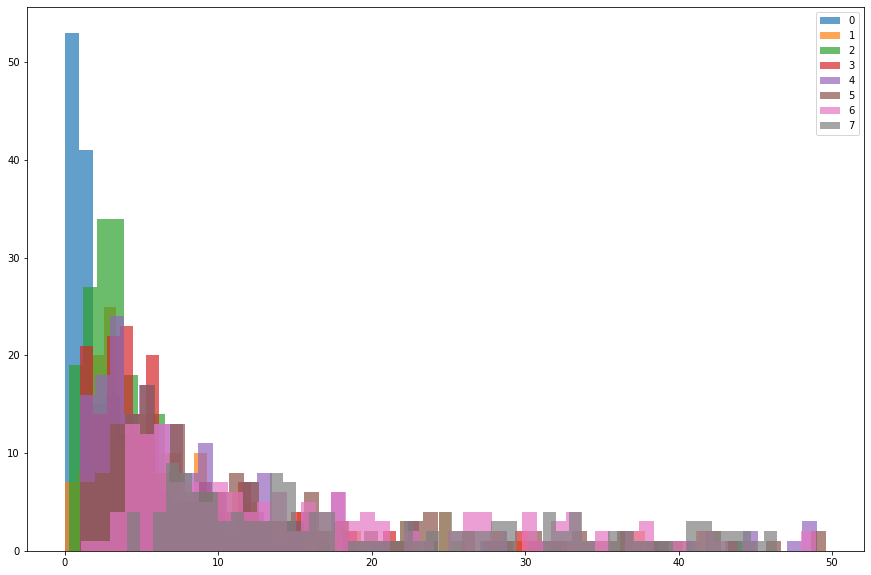

In [ ]:
import statistics
import matplotlib.pyplot as plt

plt.figure(figsize=[15, 10])

threshold = 50

layers = []
stats = []
for layer, pruned_dict in enumerate(pruned_dicts):
  layers.append(layer)
  stats.append([])
  for neuron, pruned_snippets in pruned_dict.items():
    # contexts = [index for _, index in pruned_snippets if threshold is None or index <= threshold]
    contexts = [index for _, index in pruned_snippets]
    if not contexts:
      continue
    avg_context = statistics.mean(contexts)
    if threshold is not None and avg_context > threshold:
      continue
    stats[layer].append(avg_context)
    # stats[layer].extend(contexts)

  # plt.figure(figsize=[15, 10])
  plt.hist(stats[layer], bins=50, alpha=0.7)

plt.legend(layers)